<h1 align="center"> Auto insurance - Predicting the total cost & the insurance premium of bodily injury claims - Modelling </h1>


In this notebook, after exploring the dataset, we aim to predict the total cost of third-party bodily injury claims in order to estimate the insurance premium.

We attempted two approaches:

* Predicting the total cost of third-party bodily injury claims, followed by multiplying the result of the cost predicted by the prediction of the number of third-party bodily claims (conducted in another notebook).

* Predicting the insurance premium by multiplying the actual total cost of third-party bodily injury claims by the actual number of third-party bodily claims and then generating predictions.

Both approaches were implemented using various ML algorithms such as Random Forest, Linear Regression, SGBoost, and others.

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [160]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, MaxAbsScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, r2_score, mean_squared_error, mean_absolute_error, PredictionErrorDisplay
import scipy.stats
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OrdinalEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from category_encoders import CountEncoder, TargetEncoder
import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap

## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Opening Dataset

In [10]:
# Load the training dataset
training_data = pd.read_csv('training.csv', sep=';')

In [11]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
1,200114978,2009,Male,C,Large,Employed,25,18,90,3,15080,0,L46,L,72.012883,365,1,0,0.0,0.0
2,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370,1,O38,O,39.550411,365,1,0,0.0,0.0
3,200115001,2009,Female,E,Large,Unemployed,42,11,150,0,39650,0,Q28,Q,169.529148,365,2,0,0.0,0.0
4,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600,1,L6,L,58.894688,365,1,0,0.0,0.0
5,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065,0,N4,N,109.631885,365,2,0,0.0,0.0


The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [12]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100021 entries, 1 to 100021
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PolNum      100021 non-null  int64  
 1   CalYear     100021 non-null  int64  
 2   Gender      100021 non-null  object 
 3   Type        100021 non-null  object 
 4   Category    100021 non-null  object 
 5   Occupation  100021 non-null  object 
 6   Age         100021 non-null  int64  
 7   Group1      100021 non-null  int64  
 8   Bonus       100021 non-null  int64  
 9   Poldur      100021 non-null  int64  
 10  Value       100021 non-null  int64  
 11  Adind       100021 non-null  int64  
 12  SubGroup2   100021 non-null  object 
 13  Group2      100021 non-null  object 
 14  Density     100021 non-null  float64
 15  Exppdays    100021 non-null  int64  
 16  Numtppd     100021 non-null  int64  
 17  Numtpbi     100021 non-null  int64  
 18  Indtppd     100021 non-null  float64
 19  Indtpbi

In [13]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [15]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
count,1.000210e+05,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000
mean,2.002003e+08,2009.499895,41.122514,10.692625,-6.921646,5.470781,16454.675268,0.512142,117.159270,327.588007,0.147449,0.046790,106.135007,222.762829
std,6.217239e+04,0.500002,14.299349,4.687286,48.633165,4.591194,10506.742732,0.499855,79.500907,73.564636,0.436917,0.219546,444.949188,1859.422836
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,91.000000,0.000000,0.000000,0.000000,0.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.625783,340.000000,0.000000,0.000000,0.000000,0.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14610.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22575.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292


In [16]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526


In [18]:
# Handling outliers based on standard deviations

# Define the list of numerical columns
cols_with_outliers = ['Indtpbi', 'Indtppd', 'Bonus']

# Iterate over each numerical column
for col in cols_with_outliers:
    # Calculate mean, standard deviation, and threshold
    mean = np.mean(training_data[col])
    std = np.std(training_data[col])
    threshold = 3  # I chose 3 for the number of standard deviations to use as threshold
    
    # Find outliers
    outliers = training_data[col][np.abs(training_data[col] - mean) > threshold * std]
    
    # Create a new column with processed values (replacing outliers with NaN)
    processed_col_name = col + '_processed'
    training_data[processed_col_name] = training_data[col].where(~training_data[col].isin(outliers))


In [19]:
# Replace null values with median
training_data['Indtpbi_processed'].fillna(training_data['Indtpbi_processed'].median(), inplace=True)
training_data['Indtppd_processed'].fillna(training_data['Indtppd_processed'].median(), inplace=True)
training_data['Bonus_processed'].fillna(training_data['Bonus_processed'].median(), inplace=True)

In [20]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed
count,1.000210e+05,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000,100021.000000
mean,2.002003e+08,2009.499895,41.122514,10.692625,-6.921646,5.470781,16454.675268,0.512142,117.159270,327.588007,0.147449,0.046790,106.135007,222.762829,53.431082,50.582517,-10.143570
std,6.217239e+04,0.500002,14.299349,4.687286,48.633165,4.591194,10506.742732,0.499855,79.500907,73.564636,0.436917,0.219546,444.949188,1859.422836,409.267436,193.913012,44.038319
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.625783,340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14610.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22575.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292,5796.313276,1440.666933,130.000000


In [21]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 90  30 150   0  40  80 -20 -40 120 -30  20  50 -50 -10 100  10 110 140
  70  60 130]


In [22]:
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd_processed'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi_processed'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus_processed'].unique())

Valeurs uniques de la colonne Indtppd: [  0.         740.30229036 207.32365675 ... 965.69781692 546.40798246
 822.92046036]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 90.  30. -30.   0.  40.  80. -20. -40. 120.  20.  50. -50. -10. 100.
  10. 110.  70.  60. 130.]


In [23]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])

# Calculate the 90th percentile for each numeric column
percentile_90 = numeric_cols.quantile(0.9)

# Count the number of values above the 90th percentile in each column
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculate the percentage of values above the 90th percentile in each column
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Display the percentages
print("Percentage of values above the 90th percentile in each column:")
print(percentage_above_90)

Percentage of values above the 90th percentile in each column:
PolNum               9.999900
CalYear              0.000000
Age                  9.530998
Group1               7.824357
Bonus                8.996111
Poldur               7.149499
Value                9.991902
Adind                0.000000
Density              9.701963
Exppdays             0.000000
Numtppd              1.918597
Numtpbi              4.505054
Indtppd              9.999900
Indtpbi              4.505054
Indtpbi_processed    3.283311
Indtppd_processed    9.999900
Bonus_processed      8.764160
dtype: float64


In [35]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758,0.000716,0.009395,-0.003689
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688,-0.000522,0.009171,-0.003624
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483,-0.055362,-0.106214,-0.226543
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907,0.020016,0.054272,-0.024901
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060,0.041991,0.157627,0.875649
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129,-0.004224,-0.030808,-0.009921
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563,0.008888,0.011363,-0.002279
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352,-0.027254,-0.030462,-0.047602
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282,0.014783,0.075368,-0.005018
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526,0.028113,0.051894,-0.002074


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

In [40]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtpbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtpbi: p-value = 0.8934007138622158
Cramer's V for Gender and Indtpbi: 0.20941124866173572
Chi-squared test result for Type and Indtpbi: p-value = 0.44802267811822194
Cramer's V for Type and Indtpbi: 0.47478773727715157
Chi-squared test result for Category and Indtpbi: p-value = 0.04073179482604187
Cramer's V for Category and Indtpbi: 0.30399445159088456
Chi-squared test result for Occupation and Indtpbi: p-value = 0.9999999011104369
Cramer's V for Occupation and Indtpbi: 0.4128243203114816
Chi-squared test result for Group2 and Indtpbi: p-value = 0.9951087065940399
Cramer's V for Group2 and Indtpbi: 0.6308394778142368


In [161]:
#  Creating new target variable
training_data['Prime_pbi'] = training_data['Numtpbi'] * training_data['Indtpbi_processed']

In [162]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Indtpbi_processed,Indtppd_processed,Bonus_processed,Prime_pbi
PolNum,1.000000,0.972667,0.002485,0.004175,-0.005531,-0.003895,-0.003639,0.001764,0.008203,-0.000497,0.016106,0.001217,0.016711,0.007758,0.000716,0.009395,-0.003689,-0.000103
CalYear,0.972667,1.000000,0.001821,0.003681,-0.005003,-0.002544,-0.003861,0.001795,0.008755,-0.001047,0.016180,-0.000046,0.017064,0.007688,-0.000522,0.009171,-0.003624,-0.001491
Age,0.002485,0.001821,1.000000,0.090973,-0.214690,0.050484,0.017842,0.203033,0.003174,0.000863,-0.162853,-0.097282,-0.137889,-0.054483,-0.055362,-0.106214,-0.226543,-0.055596
Group1,0.004175,0.003681,0.090973,1.000000,-0.022209,0.004490,0.231667,0.020505,0.004588,0.002743,0.091533,0.026548,0.059937,0.002907,0.020016,0.054272,-0.024901,0.020035
Bonus,-0.005531,-0.005003,-0.214690,-0.022209,1.000000,-0.008891,-0.001229,-0.040354,-0.003643,-0.002402,0.236655,0.070457,0.140030,0.037060,0.041991,0.157627,0.875649,0.041528
Poldur,-0.003895,-0.002544,0.050484,0.004490,-0.008891,1.000000,0.002306,0.012535,-0.001056,0.000464,-0.043223,-0.007521,-0.031090,-0.004129,-0.004224,-0.030808,-0.009921,-0.003846
Value,-0.003639,-0.003861,0.017842,0.231667,-0.001229,0.002306,1.000000,0.007748,0.002325,-0.002056,0.023859,0.007637,0.015581,0.001563,0.008888,0.011363,-0.002279,0.009491
Adind,0.001764,0.001795,0.203033,0.020505,-0.040354,0.012535,0.007748,1.000000,0.003019,0.001841,-0.052238,-0.039524,-0.059245,-0.020352,-0.027254,-0.030462,-0.047602,-0.027781
Density,0.008203,0.008755,0.003174,0.004588,-0.003643,-0.001056,0.002325,0.003019,1.000000,-0.003989,0.121018,0.026220,0.105476,0.021282,0.014783,0.075368,-0.005018,0.015395
Exppdays,-0.000497,-0.001047,0.000863,0.002743,-0.002402,0.000464,-0.002056,0.001841,-0.003989,1.000000,0.074080,0.048895,0.054129,0.027526,0.028113,0.051894,-0.002074,0.027667


In [163]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Prime_pbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Prime_pbi: p-value = 0.7391092354917862
Cramer's V for Gender and Prime_pbi: 0.17969513153772346
Chi-squared test result for Type and Prime_pbi: p-value = 0.8367404577633619
Cramer's V for Type and Prime_pbi: 0.4028501310507659
Chi-squared test result for Category and Prime_pbi: p-value = 0.0697702351312301
Cramer's V for Category and Prime_pbi: 0.2594736335653441
Chi-squared test result for Occupation and Prime_pbi: p-value = 0.9999999094498164
Cramer's V for Occupation and Prime_pbi: 0.35067588103269626
Chi-squared test result for Group2 and Prime_pbi: p-value = 0.958648953571275
Cramer's V for Group2 and Prime_pbi: 0.5395505156550091


#### Step 2. Feature engineering (Data pre-processing)

#### Step A. Predicting the Indtpbi : 

In [191]:
# List of column names to select
columns_to_select_Ind = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays', 
                         'Numtpbi','Indtppd_processed', 'Numtppd']

# Select the columns and assign them to X
X_Ind = training_data[columns_to_select_Ind] # features
y_Ind = training_data["Indtpbi_processed"] # target variable

In [192]:
# Identification of missing values
X_Ind.isnull().sum()

Gender               0
Type                 0
Category             0
Occupation           0
PolNum               0
CalYear              0
Age                  0
Adind                0
Density              0
Bonus_processed      0
Exppdays             0
Numtpbi              0
Indtppd_processed    0
Numtppd              0
dtype: int64

In [193]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X_Ind.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_Ind.select_dtypes(exclude=['object', 'bool']).columns

In [194]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('ordinal', OrdinalEncoder())])  # Ordinal encoding of categorical data

# Handling missing categorical data and applying frequency encoding
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('frequency_encoding', CountEncoder())])  # Frequency encoding of categorical variables

# Target encoding for categorical data
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('target_encoding', TargetEncoder())])  # Target encoding for handling categorical data

In [195]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [196]:
# As our target variable can be imbalanced
X_train_Ind, X_test_Ind, y_train_Ind, y_test_Ind = train_test_split(X_Ind, y_Ind, test_size=0.1, random_state=42)

In [197]:
preprocessor.fit(X_train_Ind, y_train_Ind)
X_train_Ind = preprocessor.transform(X_train_Ind)
X_test_Ind = preprocessor.transform(X_test_Ind)

#### Step B. Predicting the Primepbi : 

In [164]:
# List of column names to select
columns_to_select = ['Type', 'Occupation', 'Category', 'Gender', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays',
                     'Numtpbi', 'Indtppd_processed', 'Numtppd', 'Indtpbi_processed']

# Select the columns and assign them to X
X = training_data[columns_to_select] # features
y = training_data["Prime_pbi"] # target variable

In [165]:
# Identification of missing values
X.isnull().sum()

Type                 0
Occupation           0
Category             0
Gender               0
Age                  0
Adind                0
Density              0
Bonus_processed      0
Exppdays             0
Numtpbi              0
Indtppd_processed    0
Numtppd              0
Indtpbi_processed    0
dtype: int64

In [166]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns

In [167]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('ordinal', OrdinalEncoder())])  # Ordinal encoding of categorical data

# Handling missing categorical data and applying frequency encoding
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('frequency_encoding', CountEncoder())])  # Frequency encoding of categorical variables

# Target encoding for categorical data
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('target_encoding', TargetEncoder())])  # Target encoding for handling categorical data


In [168]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [169]:
# As our target variable can be imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [170]:
preprocessor.fit(X_train, y_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#### Step 3. Modelling

#### Step A. Predicting the Indtpbi : 

#### 1. Linear Regression

Intercept (reg_lin): 52.928090755148546
Coefficients (reg_lin): [ 1.96387016e+00 -2.90746280e+00  1.47769883e+00 -1.97342816e+00
 -1.98977265e-01  1.30797075e-01  3.27117909e-02  2.38413442e+02
  1.08171612e+00 -2.07713894e+00  5.68115148e-01 -5.68115148e-01
  1.47440853e+00  2.33631913e+00 -1.86733472e+00 -3.49280853e+00
 -3.35564868e+00  4.90506426e+00 -1.00048979e+00  1.10176173e+00
 -1.01271935e-01  1.49725629e+00 -1.41579025e+00 -1.85127444e+00
  1.90827836e-02  1.75072562e+00]
MAE_reg_lin_Ind:
Train_reg_lin_Ind: 59.31995109963884
Test_reg_lin_Ind: 63.84537330688998
MSE_reg_lin_Ind:
Train_reg_lin_Ind: 108902.68469522122
Test_reg_lin_Ind: 121231.21111470631
RMSE_reg_lin_Ind:
Train_reg_lin_Ind: 330.00406769496226
Test_reg_lin_Ind: 348.1827266173701
R2_SCORE_reg_lin_Ind:
Train_reg_lin_Ind: 0.34290831570016445
Test_reg_lin_Ind: 0.33877759171469135
MAPE_reg_lin_Ind - Mean Absolute Percentage Error:
Train_reg_lin_Ind: inf
Test_reg_lin_Ind: inf


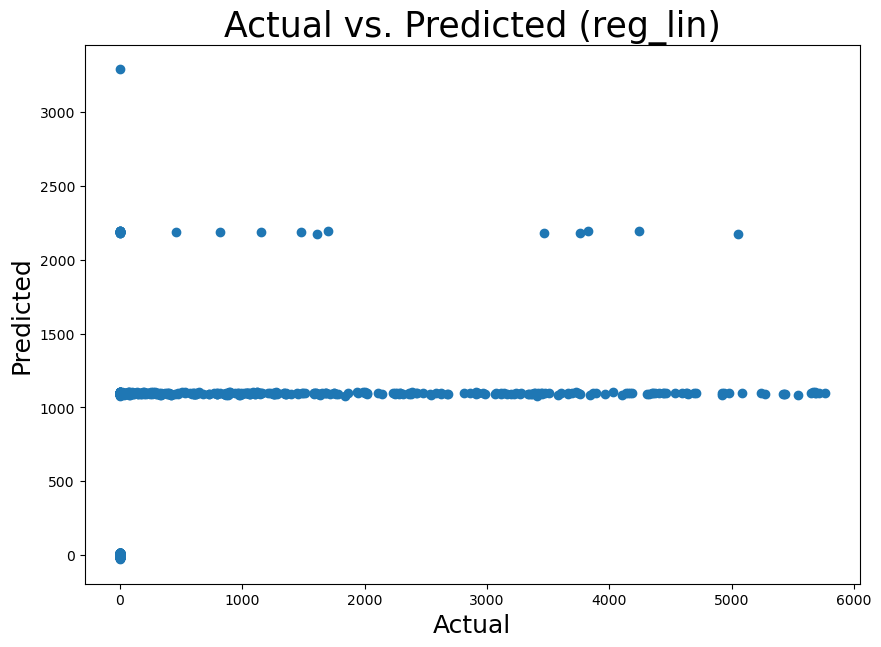

In [198]:
# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_Ind, y_train_Ind)

# Print intercept and coefficients
print("Intercept (reg_lin):", model.intercept_)
print("Coefficients (reg_lin):", model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin_Ind = model.predict(X_train_Ind)
test_predict_reg_lin_Ind = model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_absolute_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_absolute_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind)))
print("Test_reg_lin_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", r2_score(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", r2_score(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin_Ind, train_predict_reg_lin_Ind = np.array(y_train_Ind), np.array(train_predict_reg_lin_Ind)
mape_train_reg_lin_Ind = np.mean(np.abs((train_y_reg_lin_Ind - train_predict_reg_lin_Ind) / train_y_reg_lin_Ind)) * 100
print("MAPE_reg_lin_Ind - Mean Absolute Percentage Error:")
print("Train_reg_lin_Ind:", mape_train_reg_lin_Ind)
print("Test_reg_lin_Ind:", np.mean(np.abs((np.array(y_test_Ind) - np.array(test_predict_reg_lin_Ind)) / np.array(y_test_Ind))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_reg_lin_Ind)
plt.show()

#### 2. Polynomial Features

Polynomial Regression Metrics (poly_Ind):
Mean Squared Error (poly_Ind): 126624.4602426197
R-squared Score (poly_Ind): 0.3093615927813198
Intercept (poly_Ind): 572445888076.8845
Coefficients (poly_Ind): [ 6.28141817e+08 -1.18047978e+11  2.04293161e+12 ...  0.00000000e+00
  0.00000000e+00  2.91508413e+10]
MAE (poly_Ind):
Train_poly_Ind: 75.7776045440771
Test_poly_Ind: 84.99000194893146
MSE (poly_Ind):
Train_poly_Ind: 98218.55835975593
Test_poly_Ind: 126624.4602426197
RMSE (poly_Ind):
Train_poly_Ind: 313.39840197383893
Test_poly_Ind: 355.8433085539472
R2 SCORE (poly_Ind):
Train_poly_Ind: 0.407373673819579
Test_poly_Ind: 0.3093615927813198
MAPE - Mean Absolute Percentage Error (poly_Ind):
Train_poly_Ind: inf
Test_poly_Ind: inf


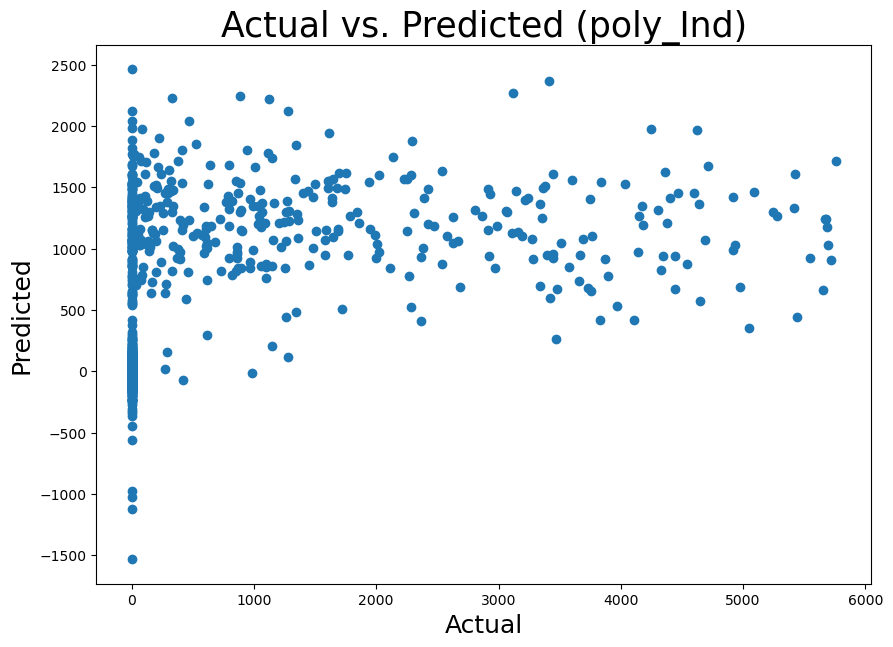

In [43]:
# Define the polynomial regression model
degree = 3  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_poly_Ind = poly_model.predict(X_test_Ind)

# Evaluate the model
mse_poly_Ind = mean_squared_error(y_test_Ind, y_pred_poly_Ind)
print("Polynomial Regression Metrics (poly_Ind):")
print(f"Mean Squared Error (poly_Ind): {mse_poly_Ind}")

r2_poly_Ind = r2_score(y_test_Ind, y_pred_poly_Ind)
print(f"R-squared Score (poly_Ind): {r2_poly_Ind}")

# Calculate other metrics
print("Intercept (poly_Ind):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_Ind):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly_Ind = poly_model.predict(X_train_Ind)
test_predict_poly_Ind = poly_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (poly_Ind):")
print("Train_poly_Ind:", mean_absolute_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_absolute_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (poly_Ind):")
print("Train_poly_Ind:", mean_squared_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_squared_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (poly_Ind):")
print("Train_poly_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_poly_Ind)))
print("Test_poly_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_poly_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (poly_Ind):")
print("Train_poly_Ind:", r2_score(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", r2_score(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_poly_Ind = np.mean(np.abs((y_train_Ind - train_predict_poly_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (poly_Ind):")
print("Train_poly_Ind:", mape_train_poly_Ind)
print("Test_poly_Ind:", np.mean(np.abs((y_test_Ind - test_predict_poly_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_poly_Ind)
plt.show()

#### 3. SVR

SVR Regression Metrics (svr_Ind):
Mean Squared Error (svr_Ind): 149555.77440335232
R-squared Score (svr_Ind): 0.1842890257823807
MAE (svr_Ind):
Train_svr_Ind: 50.37151124443768
Test_svr_Ind: 55.32959087591508
MSE (svr_Ind):
Train_svr_Ind: 135260.29273292344
Test_svr_Ind: 149555.77440335232
RMSE (svr_Ind):
Train_svr_Ind: 367.77750438671944
Test_svr_Ind: 386.72441661130256
R2 SCORE (svr_Ind):
Train_svr_Ind: 0.18387307145362275
Test_svr_Ind: 0.1842890257823807
MAPE - Mean Absolute Percentage Error (svr_Ind):
Train_svr_Ind: inf
Test_svr_Ind: inf


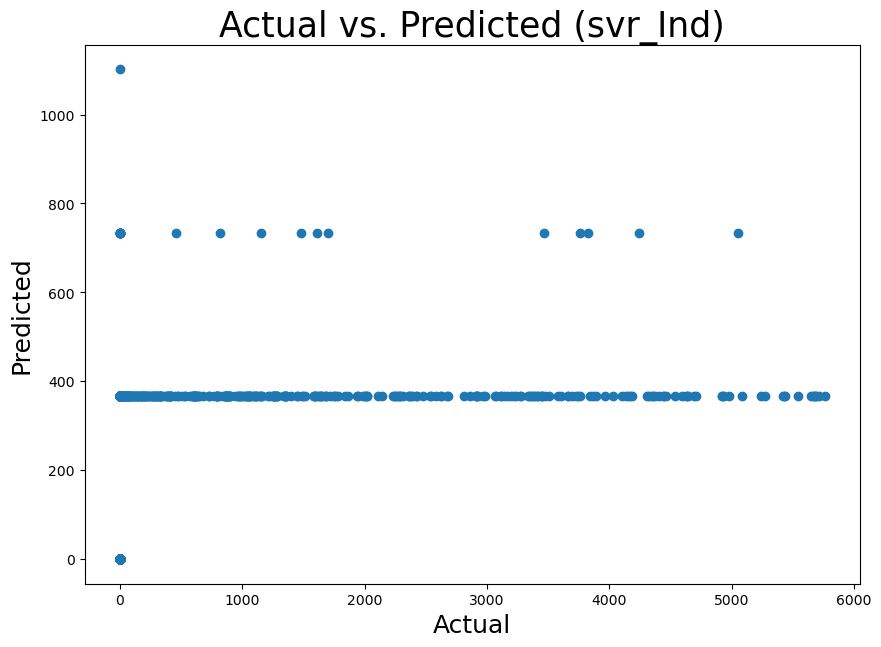

In [44]:
# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_svr_Ind = svr_model.predict(X_test_Ind)

# Evaluate the model
mse_svr_Ind = mean_squared_error(y_test_Ind, y_pred_svr_Ind)
print("SVR Regression Metrics (svr_Ind):")
print(f"Mean Squared Error (svr_Ind): {mse_svr_Ind}")

r2_svr_Ind = r2_score(y_test_Ind, y_pred_svr_Ind)
print(f"R-squared Score (svr_Ind): {r2_svr_Ind}")

# Predicting on TRAIN & TEST DATA
train_predict_svr_Ind = svr_model.predict(X_train_Ind)
test_predict_svr_Ind = svr_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (svr_Ind):")
print("Train_svr_Ind:", mean_absolute_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_absolute_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (svr_Ind):")
print("Train_svr_Ind:", mean_squared_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_squared_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (svr_Ind):")
print("Train_svr_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_svr_Ind)))
print("Test_svr_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_svr_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (svr_Ind):")
print("Train_svr_Ind:", r2_score(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", r2_score(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_svr_Ind = np.mean(np.abs((y_train_Ind - train_predict_svr_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (svr_Ind):")
print("Train_svr_Ind:", mape_train_svr_Ind)
print("Test_svr_Ind:", np.mean(np.abs((y_test_Ind - test_predict_svr_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_svr_Ind)
plt.show()

#### 4. RandomForest

Random Forest Regression Metrics (rf_Ind):
Mean Squared Error (rf_Ind): 121927.59808295607
R-squared Score (rf_Ind): 0.33497933989479545
MAE (rf_Ind):
Train_rf_Ind: 21.62823996343671
Test_rf_Ind: 61.49598907737853
MSE (rf_Ind):
Train_rf_Ind: 15882.536916363164
Test_rf_Ind: 121927.59808295607
RMSE (rf_Ind):
Train_rf_Ind: 126.02593747464513
Test_rf_Ind: 349.181325507187
R2 SCORE (rf_Ind):
Train_rf_Ind: 0.9041687267624786
Test_rf_Ind: 0.33497933989479545
MAPE - Mean Absolute Percentage Error (rf_Ind):
Train_rf_Ind: inf
Test_rf_Ind: inf


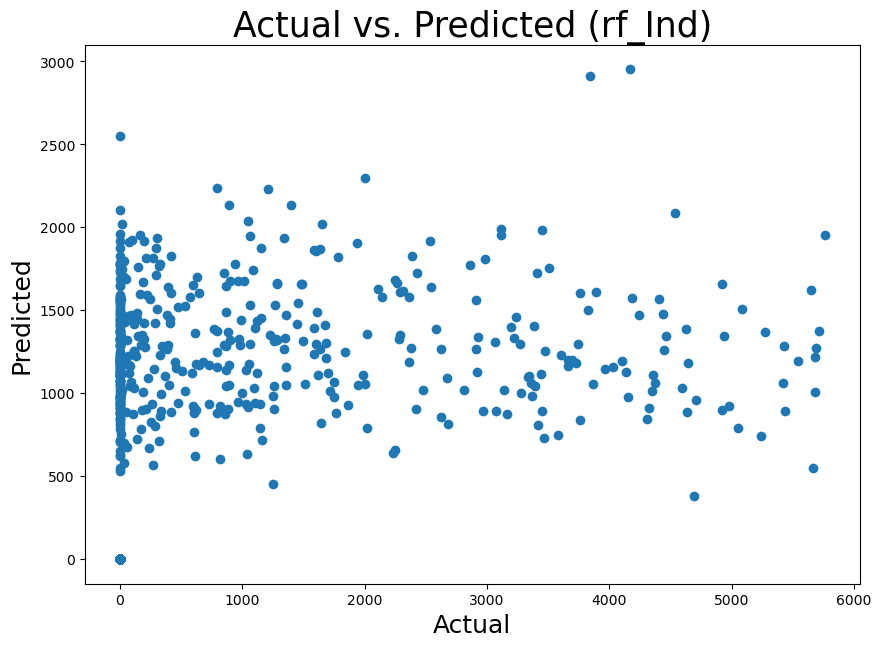

In [45]:
# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest regression model
rf_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_rf_Ind = rf_model.predict(X_test_Ind)

# Evaluate the model
mse_rf_Ind = mean_squared_error(y_test_Ind, y_pred_rf_Ind)
print("Random Forest Regression Metrics (rf_Ind):")
print(f"Mean Squared Error (rf_Ind): {mse_rf_Ind}")

r2_rf_Ind = r2_score(y_test_Ind, y_pred_rf_Ind)
print(f"R-squared Score (rf_Ind): {r2_rf_Ind}")

# Predicting on TRAIN & TEST DATA
train_predict_rf_Ind = rf_model.predict(X_train_Ind)
test_predict_rf_Ind = rf_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (rf_Ind):")
print("Train_rf_Ind:", mean_absolute_error(y_train_Ind, train_predict_rf_Ind))
print("Test_rf_Ind:", mean_absolute_error(y_test_Ind, test_predict_rf_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (rf_Ind):")
print("Train_rf_Ind:", mean_squared_error(y_train_Ind, train_predict_rf_Ind))
print("Test_rf_Ind:", mean_squared_error(y_test_Ind, test_predict_rf_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (rf_Ind):")
print("Train_rf_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_rf_Ind)))
print("Test_rf_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_rf_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (rf_Ind):")
print("Train_rf_Ind:", r2_score(y_train_Ind, train_predict_rf_Ind))
print("Test_rf_Ind:", r2_score(y_test_Ind, test_predict_rf_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind = np.mean(np.abs((y_train_Ind - train_predict_rf_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (rf_Ind):")
print("Train_rf_Ind:", mape_train_rf_Ind)
print("Test_rf_Ind:", np.mean(np.abs((y_test_Ind - test_predict_rf_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_rf_Ind)
plt.show()

#### 5. RandomForest with Grid search

Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):
Mean Squared Error (RF_GSCV_Ind): 115798.19291648513
R-squared Score (RF_GSCV_Ind): 0.3684105001402833
Best parameters found by GridSearchCV (RF_GSCV_Ind):
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 3000}
MAE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 54.96667976278896
Test_RF_GSCV_Ind: 59.43269937152245
MSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 102757.2236201029
Test_RF_GSCV_Ind: 115798.19291648513
RMSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 320.5576759650327
Test_RF_GSCV_Ind: 340.29133535323103
R2 SCORE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 0.37998849769888954
Test_RF_GSCV_Ind: 0.3684105001402833
MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):
Train_RF_GSCV_Ind: inf
Test_RF_GSCV_Ind: inf


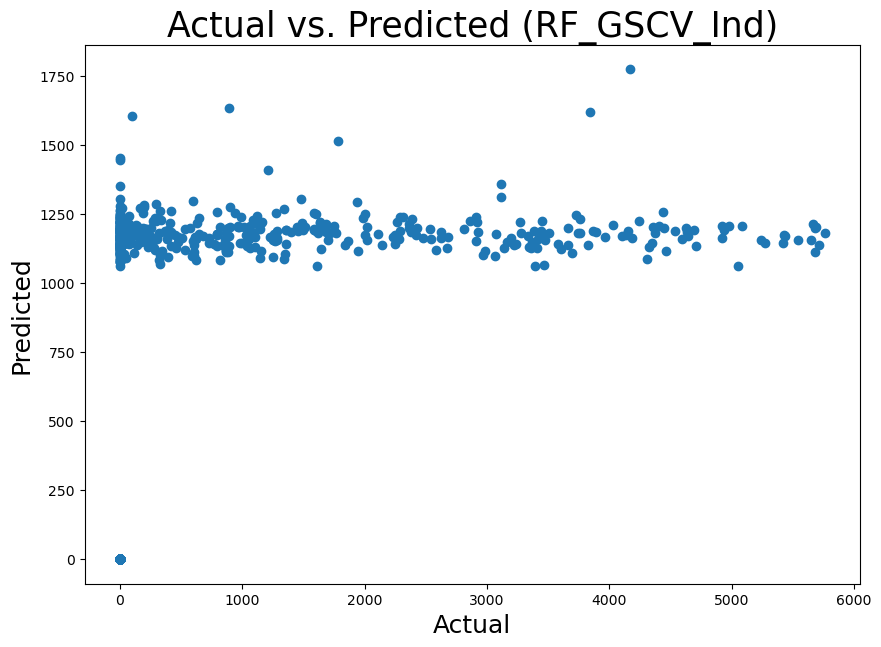

In [46]:
# Define the parameter grid for GridSearchCV
param_grid_RF_GSCV = {
    'n_estimators': [1000, 2000, 3000],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model for GridSearchCV
rf_model_RF_GSCV = RandomForestRegressor(random_state=42)

# Create GridSearchCV object for Random Forest
grid_search_RF_GSCV = GridSearchCV(estimator=rf_model_RF_GSCV, param_grid=param_grid_RF_GSCV, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search_RF_GSCV.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_rf_model_RF_GSCV = grid_search_RF_GSCV.best_estimator_

# Make predictions
y_pred_rf_grid_Ind = best_rf_model_RF_GSCV.predict(X_test_Ind)

# Evaluate the model
mse_rf_grid_Ind = mean_squared_error(y_test_Ind, y_pred_rf_grid_Ind)
print("Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):")
print(f"Mean Squared Error (RF_GSCV_Ind): {mse_rf_grid_Ind}")

r2_rf_grid_Ind = r2_score(y_test_Ind, y_pred_rf_grid_Ind)
print(f"R-squared Score (RF_GSCV_Ind): {r2_rf_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV (RF_GSCV_Ind):")
print(grid_search_RF_GSCV.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_absolute_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mean_absolute_error(y_test_Ind, y_pred_rf_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mse_rf_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind))))
print("Test_RF_GSCV_Ind:", np.sqrt(mse_rf_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", r2_score(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", r2_rf_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind = np.mean(np.abs((y_train_Ind - best_rf_model_RF_GSCV.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mape_train_rf_Ind)
print("Test_RF_GSCV_Ind:", np.mean(np.abs((y_test_Ind - y_pred_rf_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (RF_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_rf_grid_Ind)
plt.show()

#### 6. XGBoost

XGBoost Regression Metrics (XGB_Ind):
Mean Squared Error (XGB_Ind): 136184.03189103864
R-squared Score (XGB_Ind): 0.2572215297610573
MAE (XGB_Ind):
Train_Ind: 34.73622297856713
Test_Ind: 63.22671430151468
MSE (XGB_Ind):
Train_Ind: 46008.7339228419
Test_Ind: 136184.03189103864
RMSE (XGB_Ind):
Train_Ind: 214.4964659914981
Test_Ind: 369.03120720480894
R2 SCORE (XGB_Ind):
Train_Ind: 0.7223947550010237
Test_Ind: 0.2572215297610573
MAPE - Mean Absolute Percentage Error (XGB_Ind):
Train_Ind: inf
Test_Ind: inf


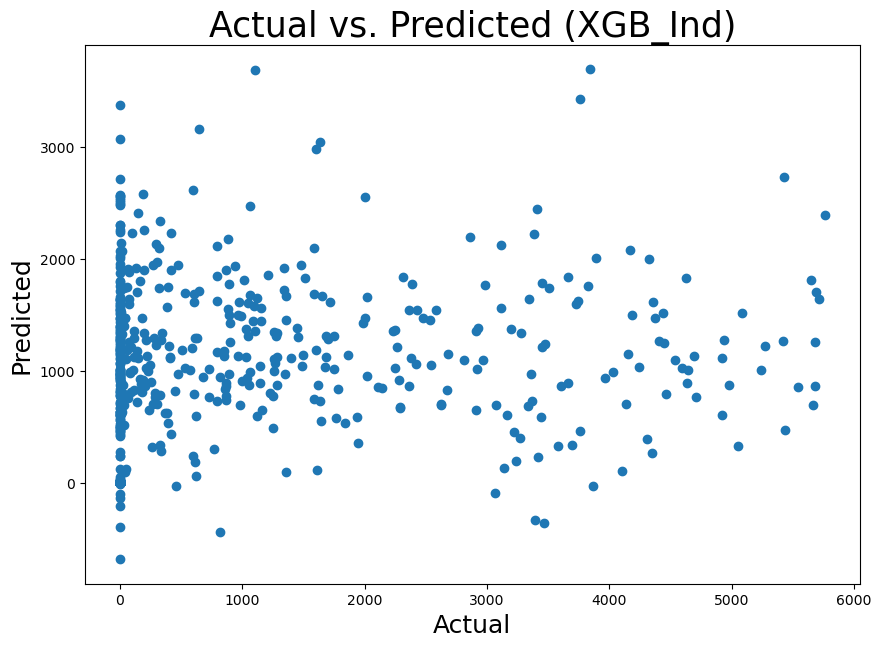

In [47]:
# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Train the XGBoost regression model
xgb_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_xgb_Ind = xgb_model.predict(X_test_Ind)

# Evaluate the model
mse_xgb_Ind = mean_squared_error(y_test_Ind, y_pred_xgb_Ind)
print("XGBoost Regression Metrics (XGB_Ind):")
print(f"Mean Squared Error (XGB_Ind): {mse_xgb_Ind}")

r2_xgb_Ind = r2_score(y_test_Ind, y_pred_xgb_Ind)
print(f"R-squared Score (XGB_Ind): {r2_xgb_Ind}")

# Print MAE (Mean Absolute Error)
print("MAE (XGB_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_xgb_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (XGB_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mse_xgb_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (XGB_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, xgb_model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_xgb_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (XGB_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, xgb_model.predict(X_train_Ind)))
print("Test_Ind:", r2_xgb_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_Ind = np.mean(np.abs((y_train_Ind - xgb_model.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (XGB_Ind):")
print("Train_Ind:", mape_train_xgb_Ind)
print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_xgb_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (XGB_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_xgb_Ind)
plt.show()

#### 7. XGBoost with GridSearch

XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:
Mean Squared Error (xgb_GSCV_Ind): 116061.32913629987
R-squared Score (xgb_GSCV_Ind): 0.36697529576202825
Best parameters found by GridSearchCV:
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 700}
MAE (xgb_GSCV_Ind):
Train_Ind: 56.17926354640679
Test_Ind: 59.99602367420819
MSE (xgb_GSCV_Ind):
Train_Ind: 105136.5143691528
Test_Ind: 116061.32913629987
RMSE (xgb_GSCV_Ind):
Train_Ind: 324.24761274241143
Test_Ind: 340.67774969360687
R2 SCORE (xgb_GSCV_Ind):
Train_Ind: 0.3656324497271831
Test_Ind: 0.36697529576202825
MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):
Train_Ind: inf
Test_Ind: inf


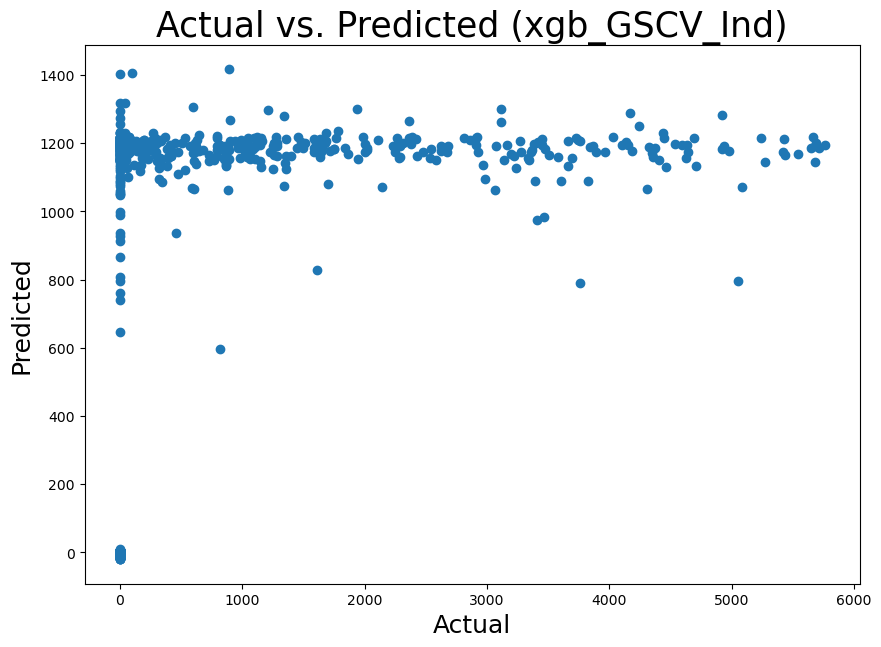

In [48]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_Ind = best_xgb_model.predict(X_test_Ind)

# Evaluate the model
mse_xgb_grid_Ind = mean_squared_error(y_test_Ind, y_pred_xgb_grid_Ind)
print("XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:")
print(f"Mean Squared Error (xgb_GSCV_Ind): {mse_xgb_grid_Ind}")

r2_xgb_grid_Ind = r2_score(y_test_Ind, y_pred_xgb_grid_Ind)
print(f"R-squared Score (xgb_GSCV_Ind): {r2_xgb_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_xgb_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mse_xgb_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (xgb_GSCV_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_xgb_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (xgb_GSCV_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", r2_xgb_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_Ind = np.mean(np.abs((y_train_Ind - best_xgb_model.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):")
print("Train_Ind:", mape_train_xgb_Ind)
print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_xgb_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_xgb_grid_Ind)
plt.show()


#### 8. ANN model

In [49]:
### Define the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_Ind.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add a dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_Ind, y_train_Ind, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse_rnn_Ind = model.evaluate(X_test_Ind, y_test_Ind)
print("Mean Squared Error (ANN_Ind):", mse_rnn_Ind)

# Make predictions on the test set
y_pred_rnn_Ind = model.predict(X_test_Ind)

# Calculate the coefficient of determination R^2
r2_rnn_Ind = r2_score(y_test_Ind, y_pred_rnn_Ind)
print("R-squared Score (ANN_Ind):", r2_rnn_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (ANN_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_rnn_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (ANN_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, model.predict(X_train_Ind)))
print("Test_Ind:", mse_rnn_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (ANN_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_rnn_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (ANN_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, model.predict(X_train_Ind)))
print("Test_Ind:", r2_rnn_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
#mape_train_rnn_Ind = np.mean(np.abs((y_train_Ind - model.predict(X_train_Ind)) / y_train_Ind)) * 100
#print("MAPE - Mean Absolute Percentage Error (ANN_Ind):")
#print("Train_Ind:", mape_train_rnn_Ind)
#print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_rnn_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
#plt.figure(figsize=(10, 7))
#plt.title("Actual vs. Predicted (ANN_Ind)", fontsize=25)
#plt.xlabel("Actual", fontsize=18)
#plt.ylabel("Predicted", fontsize=18)
#plt.scatter(x=y_test_Ind, y=y_pred_rnn_Ind)
#plt.show()

Epoch 1/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 122441.7188 - val_loss: 118666.5703
Epoch 2/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 107275.3047 - val_loss: 118035.6875
Epoch 3/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 104502.9609 - val_loss: 117871.7422
Epoch 4/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 101996.6719 - val_loss: 118483.4922
Epoch 5/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 101130.2812 - val_loss: 117663.1641
Epoch 6/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 107669.4375 - val_loss: 118304.1172
Epoch 7/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 109065.5469 - val_loss: 117603.9922
Epoch 8/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 105003.4531 - val_loss: 117240.4609
Epoch 9/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 108278.7188 - val_loss: 117558.9062
Epoch 10/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 100370.8125 - val_loss: 119031.6641
Epoch 11/50
2251/22

#### Step B. Predicting the Primepbi : 

#### 1. Linear Regression

Intercept (reg_lin_model): 54.28788565946586
Coefficients (reg_lin_model): [-1.93579510e-01 -2.78765026e-01  3.87816948e-01 -4.91854227e-01
 -1.57695844e-01  9.69756771e+00  2.60356765e-01 -7.42856102e-01
  4.14585935e+02  3.36004494e-01  9.55737425e-01 -1.10556803e-01
 -6.11767910e-01 -1.43967337e-01 -4.25449869e-01 -4.55438515e-01
  1.37030514e+00  4.85765427e-01 -1.78781533e+00  3.87183271e-01
  4.02234709e-01  3.67039566e-02 -4.38938666e-01 -2.76098212e-01
  2.76098212e-01]
MAE_reg_lin_model:
Train_reg_lin_model: 5.966818748580545
Test_reg_lin_model: 7.347322410908489
MSE_reg_lin_model:
Train_reg_lin_model: 5456.820868666718
Test_reg_lin_model: 8858.640481011507
RMSE_reg_lin_model:
Train_reg_lin_model: 73.87029760781202
Test_reg_lin_model: 94.12035104594281
R2_SCORE_reg_lin_model:
Train_reg_lin_model: 0.97003499977725
Test_reg_lin_model: 0.9580690596427015
MAPE_reg_lin_model - Mean Absolute Percentage Error:
Train_reg_lin_model: inf
Test_reg_lin_model: inf


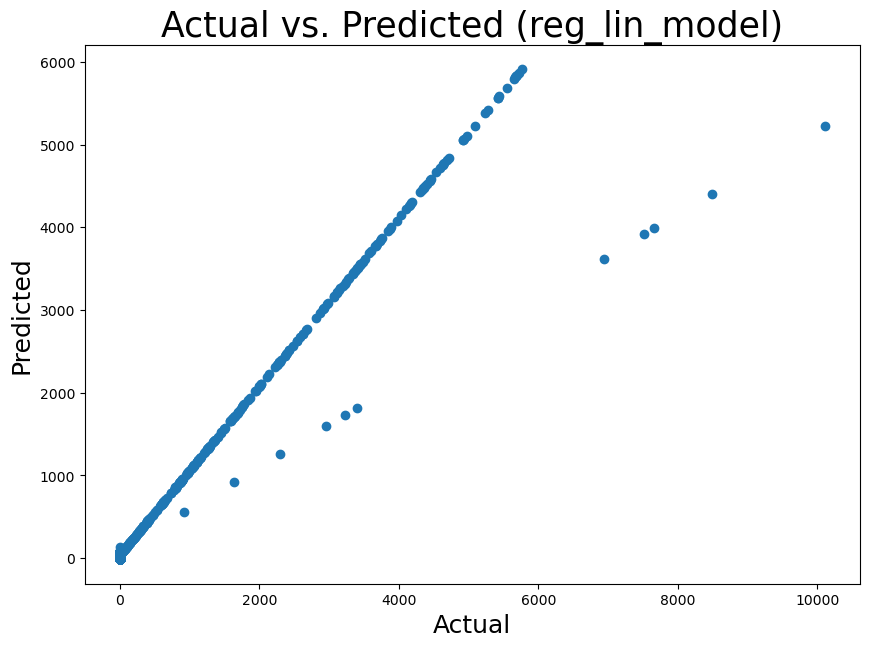

In [173]:
# Instantiate the Linear Regression model
reg_lin_model = LinearRegression()

# Fit the model on the training data
reg_lin_model.fit(X_train, y_train)

# Print intercept and coefficients
print("Intercept (reg_lin_model):", reg_lin_model.intercept_)
print("Coefficients (reg_lin_model):", reg_lin_model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin = reg_lin_model.predict(X_train)
test_predict_reg_lin = reg_lin_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_model:")
print("Train_reg_lin_model:", mean_absolute_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_absolute_error(y_test, test_predict_reg_lin))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_model:")
print("Train_reg_lin_model:", mean_squared_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_squared_error(y_test, test_predict_reg_lin))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_model:")
print("Train_reg_lin_model:", np.sqrt(mean_squared_error(y_train, train_predict_reg_lin)))
print("Test_reg_lin_model:", np.sqrt(mean_squared_error(y_test, test_predict_reg_lin)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_model:")
print("Train_reg_lin_model:", r2_score(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", r2_score(y_test, test_predict_reg_lin))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin, train_predict_reg_lin = np.array(y_train), np.array(train_predict_reg_lin)
mape_train_reg_lin = np.mean(np.abs((train_y_reg_lin - train_predict_reg_lin) / train_y_reg_lin)) * 100
print("MAPE_reg_lin_model - Mean Absolute Percentage Error:")
print("Train_reg_lin_model:", mape_train_reg_lin)
print("Test_reg_lin_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_reg_lin)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_reg_lin)
plt.show()


#### 2. Polynomial Features

Polynomial Regression Metrics:
Mean Squared Error: 3.4684631132329195e-25
R-squared Score: 1.0
Intercept (poly_model): -252.48908029940011
Coefficients (poly_model): [ 3.81630329e-03 -1.03584099e+00  5.85068924e+00  1.20605040e-01
 -9.85154987e-02  7.75253632e-01  5.29295729e+00 -9.53215965e+00
 -5.57562947e+00  7.49576624e+00  8.47760205e-03 -5.28550359e-02
  4.92103529e-02 -3.29972469e-02 -9.05229242e-02 -2.20118374e-02
 -7.09787161e-03  5.62644194e-02 -8.93402629e-03  7.71168898e-02
  5.49486279e-02 -4.64311357e-03  1.16317865e-01 -4.45494684e-02
  2.13155861e-02 -2.12637668e-02  2.13162821e-14  7.10542736e-15
  1.06581410e-14  2.48689958e-14  1.55431223e-15 -3.19744231e-14
  2.30926389e-14  3.90798505e-14 -3.90798505e-14 -1.60071150e-01
 -1.60071150e-01 -1.60071150e-01 -1.60071150e-01 -1.60071150e-01
 -1.60071150e-01  7.35288064e-01  7.35288064e-01  7.35288064e-01
  7.35288064e-01  7.35288064e-01  7.95526373e-01  7.95526373e-01
  7.95526373e-01 -3.34902300e-01 -3.34902300e-01  2.54

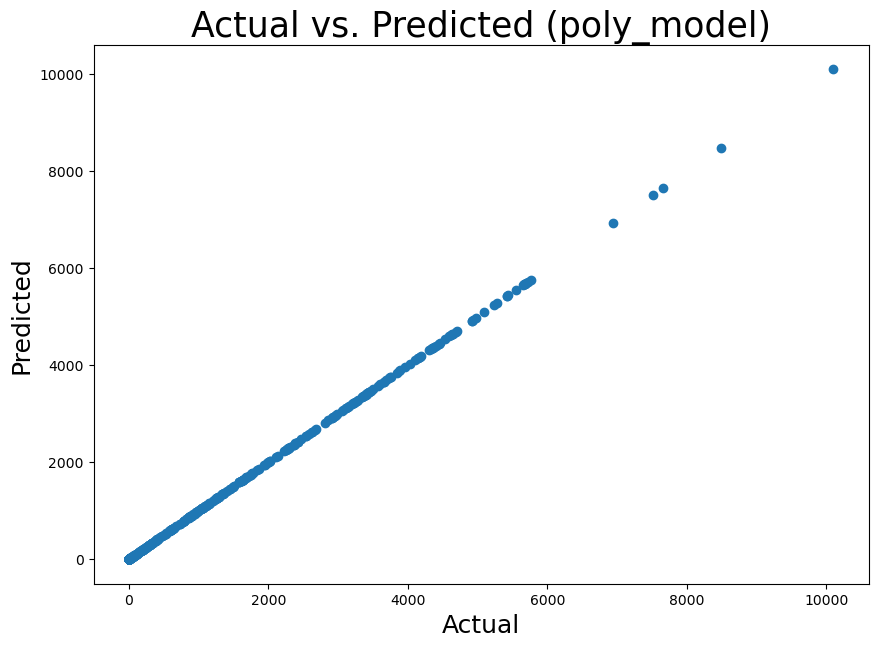

NameError: name 'ow' is not defined

In [174]:
# Define the polynomial regression model
degree = 2  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("Polynomial Regression Metrics:")
print(f"Mean Squared Error: {mse_poly}")

r2_poly = r2_score(y_test, y_pred_poly)
print(f"R-squared Score: {r2_poly}")

# Calculate other metrics
print("Intercept (poly_model):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_model):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly = poly_model.predict(X_train)
test_predict_poly = poly_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_poly_model:")
print("Train_poly_model:", mean_absolute_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_absolute_error(y_test, test_predict_poly))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_poly_model:")
print("Train_poly_model:", mean_squared_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_squared_error(y_test, test_predict_poly))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_poly_model:")
print("Train_poly_model:", np.sqrt(mean_squared_error(y_train, train_predict_poly)))
print("Test_poly_model:", np.sqrt(mean_squared_error(y_test, test_predict_poly)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_poly_model:")
print("Train_poly_model:", r2_score(y_train, train_predict_poly))
print("Test_poly_model:", r2_score(y_test, test_predict_poly))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_poly, train_predict_poly = np.array(y_train), np.array(train_predict_poly)
mape_train_poly = np.mean(np.abs((train_y_poly - train_predict_poly) / train_y_poly)) * 100
print("MAPE_poly_model - Mean Absolute Percentage Error:")
print("Train_poly_model:", mape_train_poly)
print("Test_poly_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_poly)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_poly)
plt.show()



#### 3. SVR

SVR Regression Metrics:
Mean Squared Error (svr_model): 9417.553001439604
R-squared Score (svr_model): 0.9554235377243832
MAE_svr_model:
Train_svr_model: 1.6206549145590217
Test_svr_model: 2.8542857444400327
MSE_svr_model:
Train_svr_model: 5694.51646346309
Test_svr_model: 9417.553001439604
RMSE_svr_model:
Train_svr_model: 75.46202000651115
Test_svr_model: 97.0440776216643
R2_SCORE_svr_model:
Train_svr_model: 0.9687297437092127
Test_svr_model: 0.9554235377243832
MAPE_svr_model - Mean Absolute Percentage Error:
Train_svr_model: inf
Test_svr_model: inf


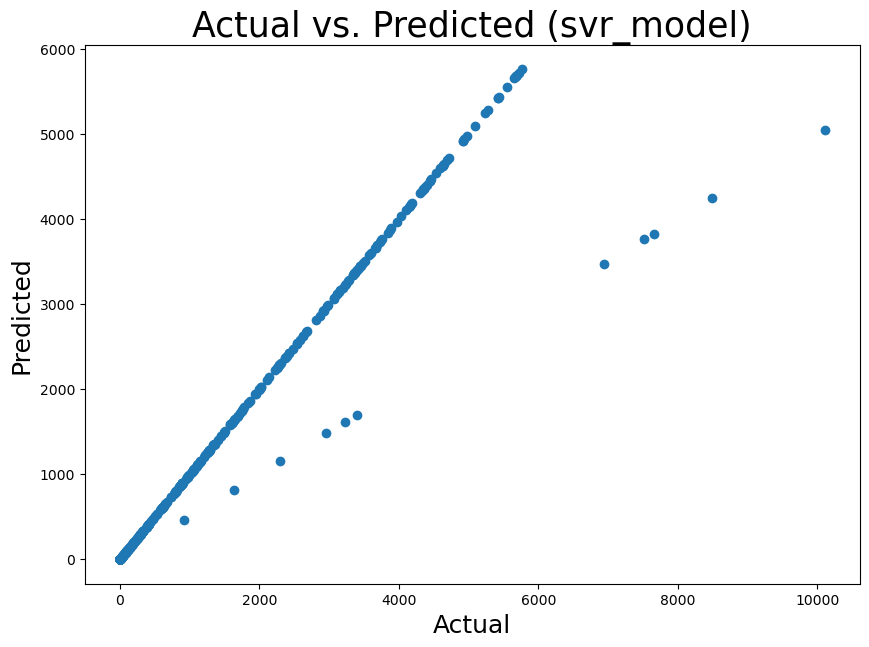

In [175]:

# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
print("SVR Regression Metrics:")
print(f"Mean Squared Error (svr_model): {mse_svr}")

r2_svr = r2_score(y_test, y_pred_svr)
print(f"R-squared Score (svr_model): {r2_svr}")

# Predicting on TRAIN & TEST DATA
train_predict_svr = svr_model.predict(X_train)
test_predict_svr = svr_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_svr_model:")
print("Train_svr_model:", mean_absolute_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_absolute_error(y_test, test_predict_svr))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_svr_model:")
print("Train_svr_model:", mean_squared_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_squared_error(y_test, test_predict_svr))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_svr_model:")
print("Train_svr_model:", np.sqrt(mean_squared_error(y_train, train_predict_svr)))
print("Test_svr_model:", np.sqrt(mean_squared_error(y_test, test_predict_svr)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_svr_model:")
print("Train_svr_model:", r2_score(y_train, train_predict_svr))
print("Test_svr_model:", r2_score(y_test, test_predict_svr))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_svr, train_predict_svr = np.array(y_train), np.array(train_predict_svr)
mape_train_svr = np.mean(np.abs((train_y_svr - train_predict_svr) / train_y_svr)) * 100
print("MAPE_svr_model - Mean Absolute Percentage Error:")
print("Train_svr_model:", mape_train_svr)
print("Test_svr_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_svr)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_svr)
plt.show()

#### 4. RandomForest

Random Forest Regression Metrics:
Mean Squared Error (rf_model): 166.61642863710912
R-squared Score (rf_model): 0.999211348112986
MAE_rf_model:
Train_rf_model: 0.10866996219790981
Test_rf_model: 0.3827326388668933
MSE_rf_model:
Train_rf_model: 44.87206031826978
Test_rf_model: 166.61642863710912
RMSE_rf_model:
Train_rf_model: 6.698661083998039
Test_rf_model: 12.907998630194733
R2_SCORE_rf_model:
Train_rf_model: 0.9997535943858533
Test_rf_model: 0.999211348112986
MAPE_rf_model - Mean Absolute Percentage Error:
Train_rf_model: nan
Test_rf_model: nan


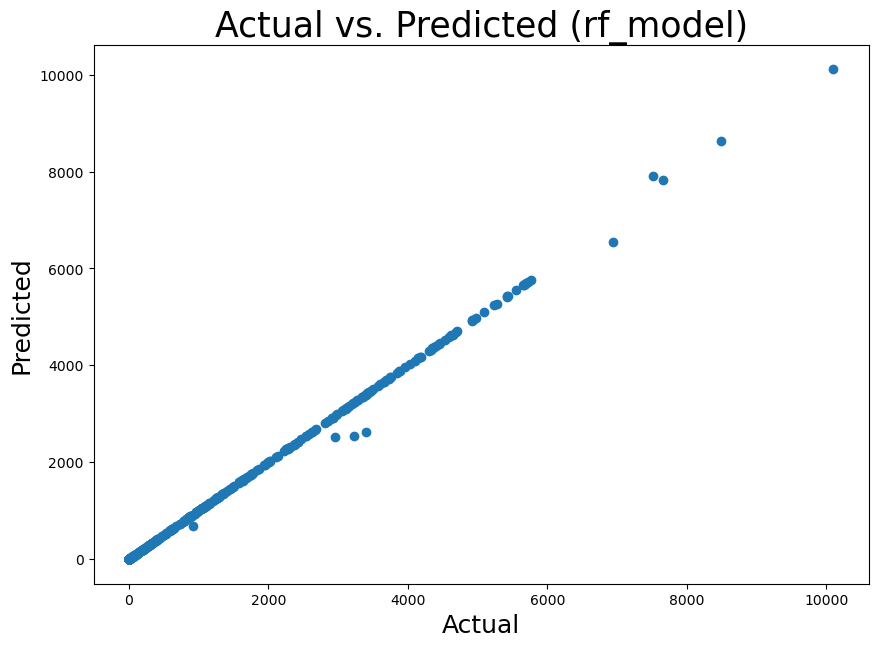

In [176]:
# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest regression model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_model = rf_model.predict(X_test)

# Evaluate the model
mse_rf_model = mean_squared_error(y_test, y_pred_rf_model)
print("Random Forest Regression Metrics:")
print(f"Mean Squared Error (rf_model): {mse_rf_model}")

r2_rf_model = r2_score(y_test, y_pred_rf_model)
print(f"R-squared Score (rf_model): {r2_rf_model}")

# Predicting on TRAIN & TEST DATA
train_predict_rf_model = rf_model.predict(X_train)
test_predict_rf_model = rf_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_rf_model:")
print("Train_rf_model:", mean_absolute_error(y_train, train_predict_rf_model))
print("Test_rf_model:", mean_absolute_error(y_test, test_predict_rf_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_model:")
print("Train_rf_model:", mean_squared_error(y_train, train_predict_rf_model))
print("Test_rf_model:", mean_squared_error(y_test, test_predict_rf_model))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_model:")
print("Train_rf_model:", np.sqrt(mean_squared_error(y_train, train_predict_rf_model)))
print("Test_rf_model:", np.sqrt(mean_squared_error(y_test, test_predict_rf_model)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_model:")
print("Train_rf_model:", r2_score(y_train, train_predict_rf_model))
print("Test_rf_model:", r2_score(y_test, test_predict_rf_model))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_rf_model, train_predict_rf_model = np.array(y_train), np.array(train_predict_rf_model)
mape_train_rf_model = np.mean(np.abs((train_y_rf_model - train_predict_rf_model) / train_y_rf_model)) * 100
print("MAPE_rf_model - Mean Absolute Percentage Error:")
print("Train_rf_model:", mape_train_rf_model)
print("Test_rf_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_rf_model)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_rf_model)
plt.show()


#### 5. RandomForest with Grid Search

Random Forest Regression Metrics (with GridSearchCV):
Mean Squared Error (rf_grid_model): 131.13929043980883
R-squared Score (rf_grid_model): 0.9993792734023108
Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE_rf_grid_model:
Train_rf_grid_model: 0.11276143858144012
Test_rf_grid_model: 0.35572151418412606
MSE_rf_grid_model:
Train_rf_grid_model: 42.43505899834571
Test_rf_grid_model: 131.13929043980883
RMSE_rf_grid_model:
Train_rf_grid_model: 6.514219753611764
Test_rf_grid_model: 11.451606456729502
R2_SCORE_rf_grid_model:
Train_rf_grid_model: 0.9997669766732422
Test_rf_grid_model: 0.9993792734023108
MAPE_rf_grid_model - Mean Absolute Percentage Error:
Train_rf_grid_model: inf
Test_rf_grid_model: inf


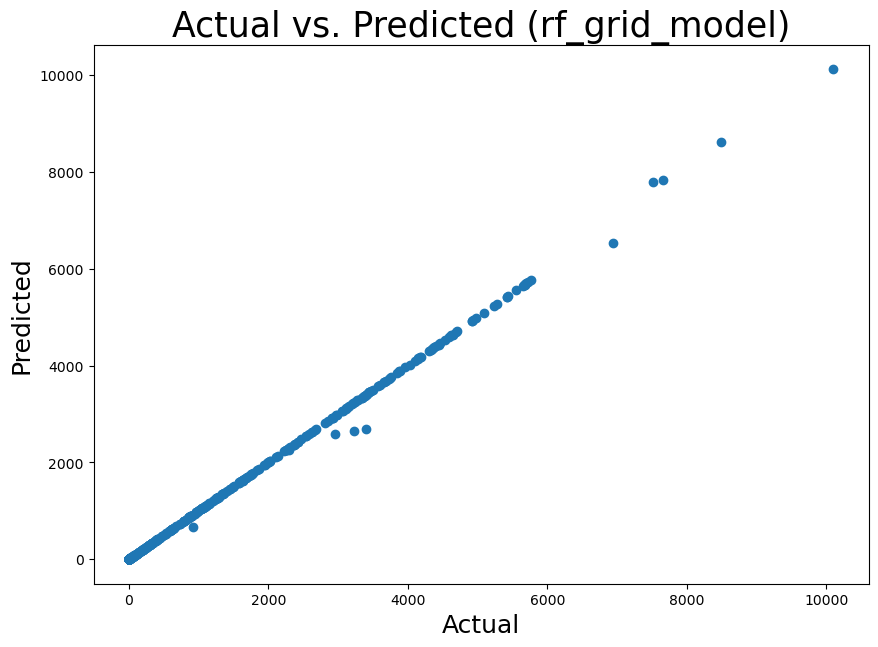

In [177]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_rf_grid_model = best_rf_model.predict(X_test)

# Evaluate the model
mse_rf_grid_model = mean_squared_error(y_test, y_pred_rf_grid_model)
print("Random Forest Regression Metrics (with GridSearchCV):")
print(f"Mean Squared Error (rf_grid_model): {mse_rf_grid_model}")

r2_rf_grid_model = r2_score(y_test, y_pred_rf_grid_model)
print(f"R-squared Score (rf_grid_model): {r2_rf_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_rf_grid_model:")
print("Train_rf_grid_model:", mean_absolute_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mean_absolute_error(y_test, y_pred_rf_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_grid_model:")
print("Train_rf_grid_model:", mean_squared_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mse_rf_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_grid_model:")
print("Train_rf_grid_model:", np.sqrt(mean_squared_error(y_train, best_rf_model.predict(X_train))))
print("Test_rf_grid_model:", np.sqrt(mse_rf_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_grid_model:")
print("Train_rf_grid_model:", r2_score(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", r2_rf_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_grid_model = np.mean(np.abs((y_train - best_rf_model.predict(X_train)) / y_train)) * 100
print("MAPE_rf_grid_model - Mean Absolute Percentage Error:")
print("Train_rf_grid_model:", mape_train_rf_grid_model)
print("Test_rf_grid_model:", np.mean(np.abs((y_test - y_pred_rf_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_grid_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_rf_grid_model)
plt.show()

#### 6. XGBoost

XGBoost Regression Metrics (xgb_model):
Mean Squared Error (xgb_model): 238.41659081872373
R-squared Score (xgb_model): 0.9988714936709263
MAE_xgb_model:
Train_xgb_model: 0.10588633454825115
Test_xgb_model: 0.6016319288045437
MSE_xgb_model:
Train_xgb_model: 0.6646664129830966
Test_xgb_model: 238.41659081872373
RMSE_xgb_model:
Train_xgb_model: 0.8152707605348646
Test_xgb_model: 15.440744503382074
R2_SCORE_xgb_model:
Train_xgb_model: 0.9999963501222245
Test_xgb_model: 0.9988714936709263
MAPE_xgb_model - Mean Absolute Percentage Error:
Train_xgb_model: inf
Test_xgb_model: inf


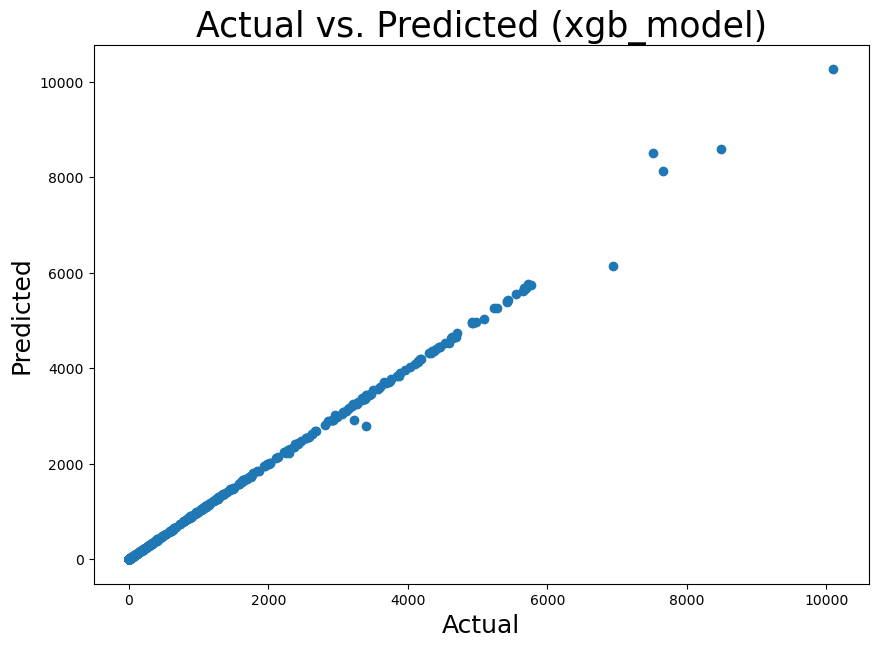

In [199]:
# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Train the XGBoost regression model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb_model = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb_model = mean_squared_error(y_test, y_pred_xgb_model)
print("XGBoost Regression Metrics (xgb_model):")
print(f"Mean Squared Error (xgb_model): {mse_xgb_model}")

r2_xgb_model = r2_score(y_test, y_pred_xgb_model)
print(f"R-squared Score (xgb_model): {r2_xgb_model}")

# Print MAE (Mean Absolute Error)
print("MAE_xgb_model:")
print("Train_xgb_model:", mean_absolute_error(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", mean_absolute_error(y_test, y_pred_xgb_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_xgb_model:")
print("Train_xgb_model:", mean_squared_error(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", mse_xgb_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_xgb_model:")
print("Train_xgb_model:", np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train))))
print("Test_xgb_model:", np.sqrt(mse_xgb_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_xgb_model:")
print("Train_xgb_model:", r2_score(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", r2_xgb_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_model = np.mean(np.abs((y_train - xgb_model.predict(X_train)) / y_train)) * 100
print("MAPE_xgb_model - Mean Absolute Percentage Error:")
print("Train_xgb_model:", mape_train_xgb_model)
print("Test_xgb_model:", np.mean(np.abs((y_test - y_pred_xgb_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_model)
plt.show()

#### 7. XGBoost with Grid Search

XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):
Mean Squared Error (best_xgb_model_grid): 30.890870700526488
R-squared Score (best_xgb_model_grid): 0.9998537830652791
Best parameters found by GridSearchCV:
{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 900}
MAE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.21989925113622488
Test_best_xgb_model_grid: 0.40663706915187026
MSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 3.4510021298256666
Test_best_xgb_model_grid: 30.890870700526488
RMSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 1.857687306794571
Test_best_xgb_model_grid: 5.557955622396286
R2_SCORE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.9999810495374362
Test_best_xgb_model_grid: 0.9998537830652791
MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:
Train_best_xgb_model_grid: inf
Test_best_xgb_model_grid: inf


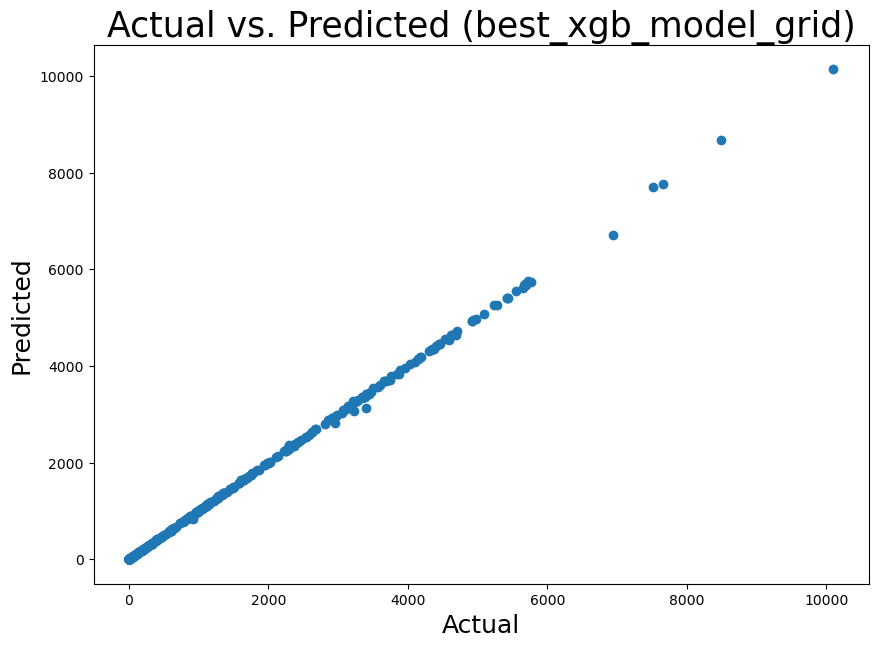

In [200]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model_grid = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_model = best_xgb_model_grid.predict(X_test)

# Evaluate the model
mse_xgb_grid_model = mean_squared_error(y_test, y_pred_xgb_grid_model)
print("XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):")
print(f"Mean Squared Error (best_xgb_model_grid): {mse_xgb_grid_model}")

r2_xgb_grid_model = r2_score(y_test, y_pred_xgb_grid_model)
print(f"R-squared Score (best_xgb_model_grid): {r2_xgb_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_absolute_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mean_absolute_error(y_test, y_pred_xgb_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_squared_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mse_xgb_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", np.sqrt(mean_squared_error(y_train, best_xgb_model_grid.predict(X_train))))
print("Test_best_xgb_model_grid:", np.sqrt(mse_xgb_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", r2_score(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", r2_xgb_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_grid_model = np.mean(np.abs((y_train - best_xgb_model_grid.predict(X_train)) / y_train)) * 100
print("MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:")
print("Train_best_xgb_model_grid:", mape_train_xgb_grid_model)
print("Test_best_xgb_model_grid:", np.mean(np.abs((y_test - y_pred_xgb_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (best_xgb_model_grid)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_grid_model)
plt.show()


#### 8. ANN

In [201]:
# Define the ANN model
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add a dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1)
])

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse_ann = ann_model.evaluate(X_test, y_test)
print("Mean Squared Error (ann_model):", mse_ann)

# Make predictions on the test set
y_pred_ann_model = ann_model.predict(X_test)

# Calculate the coefficient of determination R^2
r2_ann_model = r2_score(y_test, y_pred_ann_model)
print("R-squared Score (ann_model):", r2_ann_model)

# Print MAE (Mean Absolute Error)
print("MAE_ann_model:")
print("Train_ann_model:", mean_absolute_error(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", mean_absolute_error(y_test, y_pred_ann_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_ann_model:")
print("Train_ann_model:", mean_squared_error(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", mse_ann)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_ann_model:")
print("Train_ann_model:", np.sqrt(mean_squared_error(y_train, ann_model.predict(X_train))))
print("Test_ann_model:", np.sqrt(mse_ann))
print("====================================")

# Print R2 SCORE
print("R2 SCORE_ann_model:")
print("Train_ann_model:", r2_score(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", r2_ann_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
#mape_train_ann_model = np.mean(np.abs((y_train - ann_model.predict(X_train)) / y_train)) * 100
#print("MAPE_ann_model - Mean Absolute Percentage Error:")
#print("Train_ann_model:", mape_train_ann_model)
#print("Test_ann_model:", np.mean(np.abs((y_test - y_pred_ann_model) / y_test)) * 100)

# Plot actual vs predicted value
#plt.figure(figsize=(10, 7))
#plt.title("Actual vs. Predicted (ann_model)", fontsize=25)
#plt.xlabel("Actual", fontsize=18)
#plt.ylabel("Predicted", fontsize=18)
#plt.scatter(x=y_test, y=y_pred_ann_model)
#plt.show()


Epoch 1/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 80164.2188 - val_loss: 2875.5264
Epoch 2/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7695.6499 - val_loss: 2614.3630
Epoch 3/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8688.0488 - val_loss: 2231.9121
Epoch 4/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5206.3223 - val_loss: 1957.4647
Epoch 5/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5024.7148 - val_loss: 1711.8605
Epoch 6/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5613.1465 - val_loss: 1611.0594
Epoch 7/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3576.2778 - val_loss: 1729.1740
Epoch 8/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4801.8623 - val_loss: 963.9003
Epoch 9/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3537.4121 - val_loss: 740.8914
Epoch 10/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4208.5884 - val_loss: 616.2075
Epoch 11/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss

#### Step 4. Interpretability

#### Step A: Predicting IndtPBI

In [55]:

# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'SVR', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin_Ind, test_predict_poly_Ind, test_predict_svr_Ind, test_predict_rf_Ind, y_pred_rf_grid_Ind, y_pred_xgb_Ind, y_pred_xgb_grid_Ind, y_pred_rnn_Ind]

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_test_Ind, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_test_Ind, y_pred) for y_pred in all_y_pred]
}

# Debugging: Print shapes of all_y_pred
for i, y_pred in enumerate(all_y_pred):
    print(f'Shape of y_pred_{model_names[i]}: {y_pred.shape}')

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
df_predictions

Shape of y_pred_Linear Regression: (10003,)
Shape of y_pred_Polynomial Regression: (10003,)
Shape of y_pred_SVR: (10003,)
Shape of y_pred_Random Forest: (10003,)
Shape of y_pred_Random Forest With GridSearch: (10003,)
Shape of y_pred_XGBoost: (10003,)
Shape of y_pred_XGBoost With GridSearch: (10003,)
Shape of y_pred_ANN: (10003, 1)

Predictions DataFrame:


,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_SVR,y_pred_Random Forest,y_pred_Random Forest With GridSearch,y_pred_XGBoost,y_pred_XGBoost With GridSearch,y_pred_ANN
0,3.851543,36.537598,0.099748,0.000000,0.000000,-0.005510,-0.110864,-0.119587
1,-3.372916,15.755615,-0.099569,0.000000,0.000000,-0.319142,2.921796,1.298091
2,5.534681,-9.968872,0.099942,0.000000,0.000000,-0.109874,-0.110978,0.207762
3,1099.310116,713.989014,367.381019,801.552782,1120.333906,797.856995,1198.665039,559.590698
4,-0.145959,22.312744,-0.099895,0.000000,0.000000,-0.025021,3.287796,0.853833
...,...,...,...,...,...,...,...,...
9998,3.226614,-62.375977,0.099672,0.000000,0.000000,-0.029439,-0.171975,0.526853
9999,4.071539,52.992676,0.099993,0.000000,0.000000,0.004390,-0.171975,0.632753
10000,1.912650,3.540405,-0.099598,0.000000,0.000000,0.046329,2.084635,1.550418
10001,-12.908988,-91.627686,-0.099598,0.000000,0.000000,-0.490083,-11.671545,0.452966


In [56]:
print("\nMetrics DataFrame:")
df_metrics


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,63.845373,121231.211115,348.182727,0.338778
1,Polynomial Regression,84.990002,126624.460243,355.843309,0.309362
2,SVR,55.329591,149555.774403,386.724417,0.184289
3,Random Forest,61.495989,121927.598083,349.181326,0.334979
4,Random Forest With GridSearch,59.432699,115798.192916,340.291335,0.368411
5,XGBoost,63.226714,136184.031891,369.031207,0.257222
6,XGBoost With GridSearch,59.996024,116061.329136,340.677750,0.366975
7,ANN,59.208689,122803.243325,350.432937,0.330203


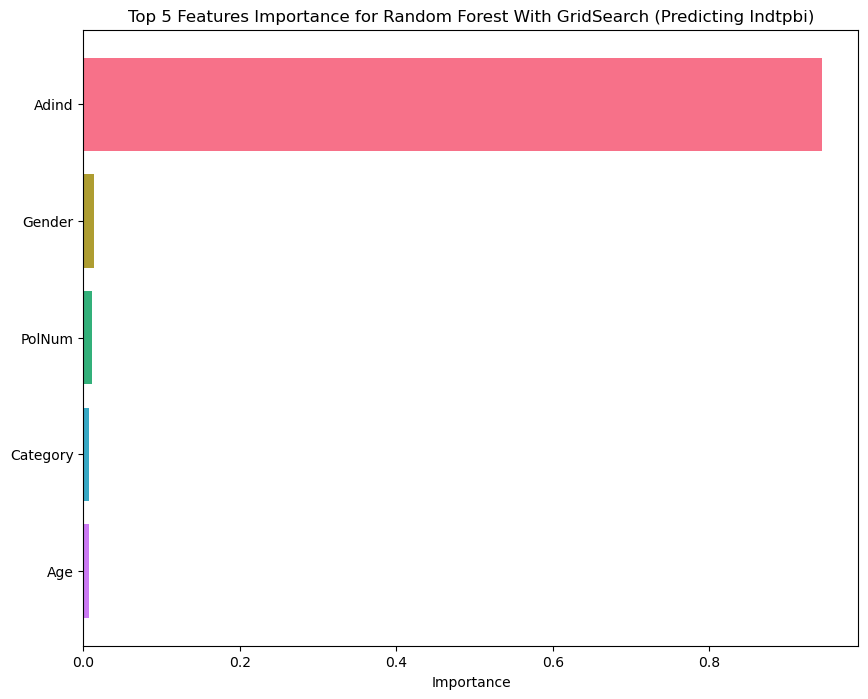

In [90]:
# Retrieve the best estimator
best_rf_model = grid_search_RF_GSCV.best_estimator_
feature_importances = best_rf_model.feature_importances_

# List of feature names
feature_names = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays',
                     'Numtpbi', 'Indtppd_processed', 'Numtppd']

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)

# Select the top 5 most important features
top_5_idx = sorted_idx[-5:]

# Define your custom color palette
custom_palette = sns.color_palette("husl", 5) 

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(5), feature_importances[top_5_idx][::-1], color=custom_palette)
plt.yticks(range(5), np.array(feature_names)[top_5_idx][::-1])  # Reverse the order for display
plt.xlabel('Importance')
plt.title('Top 5 Features Importance for Random Forest With GridSearch (Predicting Indtpbi)')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


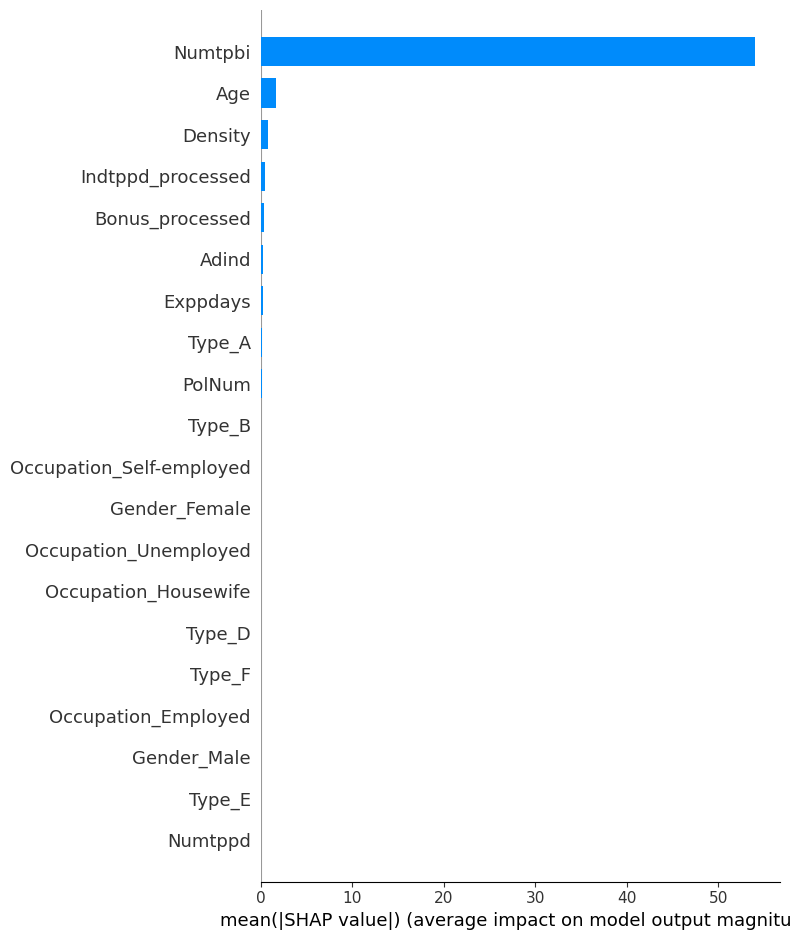

In [118]:
# Explainability with SHAP

# One-hot encode categorical features
X_Ind_encoded = pd.get_dummies(X_Ind)

# Convert DataFrame to NumPy array
X_Ind_encoded_array = X_Ind_encoded.values

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_Ind_encoded_array)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, plot_type="bar", feature_names=X_Ind_encoded.columns)


In [125]:
# Create a DataFrame of SHAP values with feature names
shap_df = pd.DataFrame(shap_values, columns=X_Ind_encoded.columns)

# Display the DataFrame
shap_df.head()


,PolNum,CalYear,Age,Adind,Density,Bonus_processed,Exppdays,Numtpbi,Indtppd_processed,Numtppd,...,Type_E,Type_F,Category_Large,Category_Medium,Category_Small,Occupation_Employed,Occupation_Housewife,Occupation_Retired,Occupation_Self-employed,Occupation_Unemployed
0,0.083411,-0.011749,1.807248,-0.210613,-0.826304,0.520296,-0.232294,-53.832245,0.044970,-0.108713,...,0.006698,-0.021402,0.039726,-0.010027,-0.004569,0.063826,-0.030671,0.002065,0.053377,-0.019113
1,0.018977,-0.011749,1.868747,-0.198675,-0.823105,0.540168,-0.231682,-53.773499,0.050213,-0.097239,...,-0.063846,-0.021424,0.038947,-0.008969,-0.008537,0.064960,-0.031484,0.002059,0.053583,-0.019979
2,-0.162182,-0.011591,1.804670,-0.216131,-0.709555,0.370740,-0.218190,-53.618672,0.025378,-0.095112,...,-0.130059,-0.023033,0.031230,-0.003541,-0.008999,-0.021128,-0.027221,0.002259,0.050706,0.159992
3,-0.106553,-0.011066,1.512688,-0.216785,-0.837799,-0.277817,-0.214301,-52.630102,0.017405,-0.107258,...,0.015286,-0.022821,-0.015337,0.017040,-0.004038,-0.023220,0.087451,0.002167,0.055202,-0.020199
4,0.236472,-0.011468,1.939556,-0.223802,-0.763831,0.501965,-0.243606,-54.173298,0.049588,-0.118492,...,0.006996,-0.021796,0.040049,-0.006047,-0.009570,0.067473,-0.029624,0.002147,0.054881,-0.020026


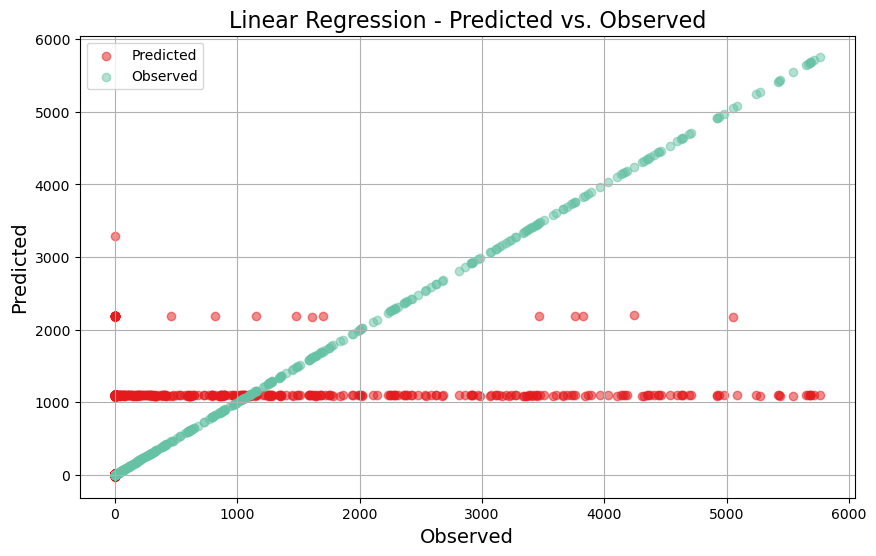

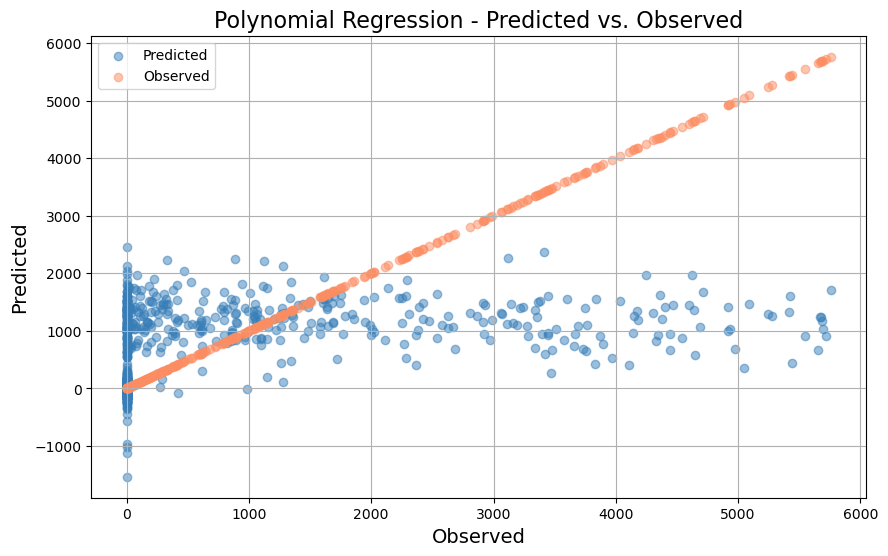

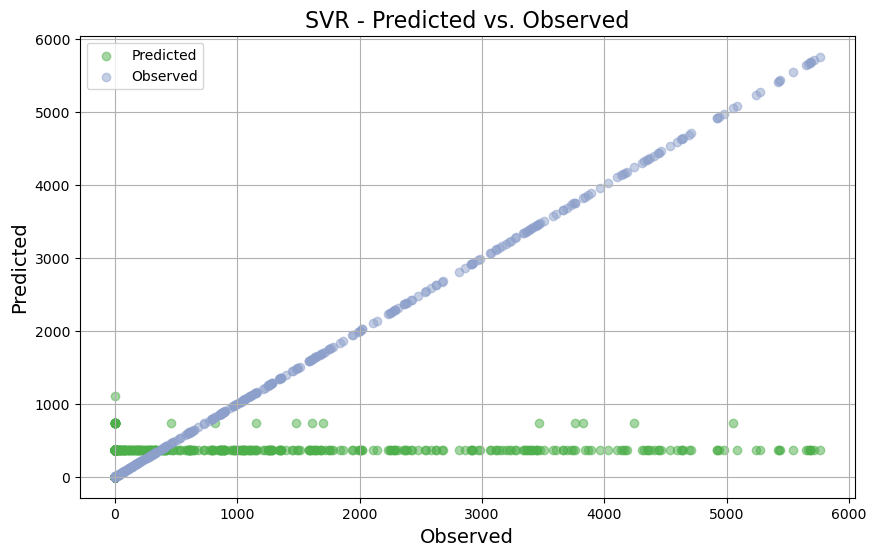

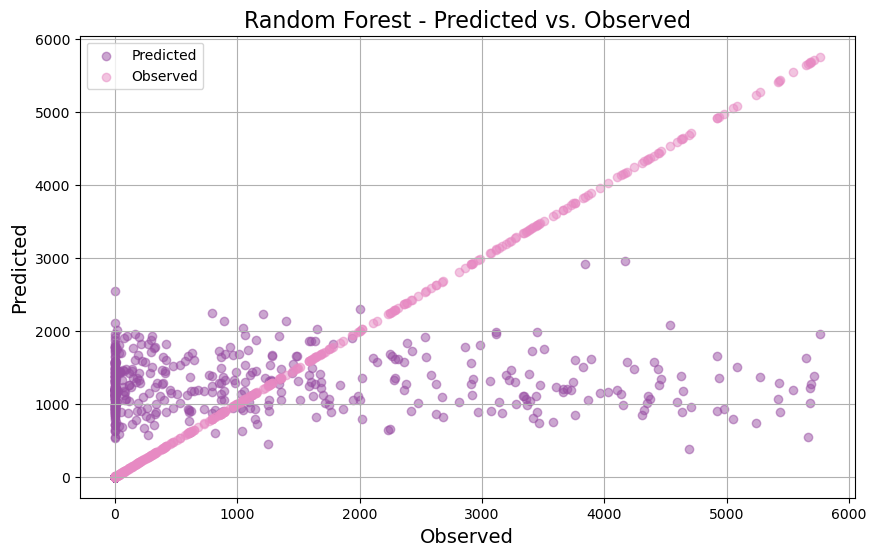

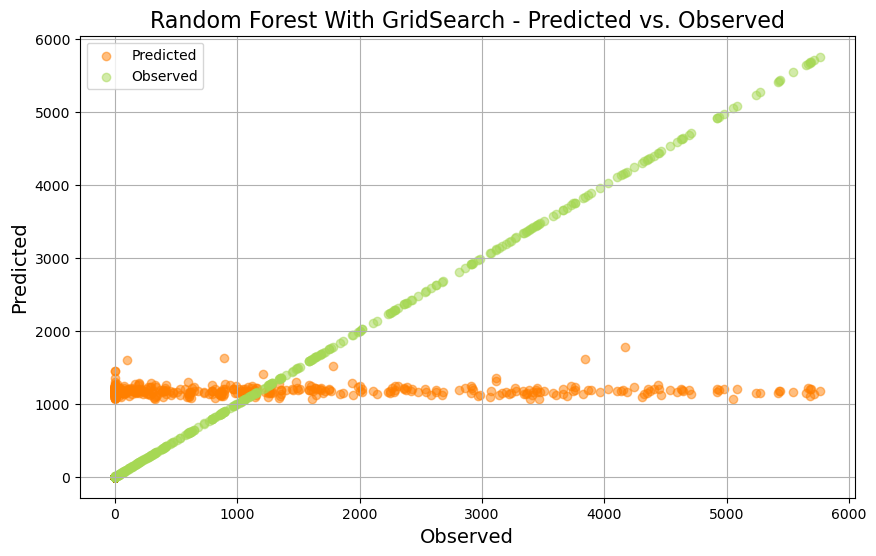

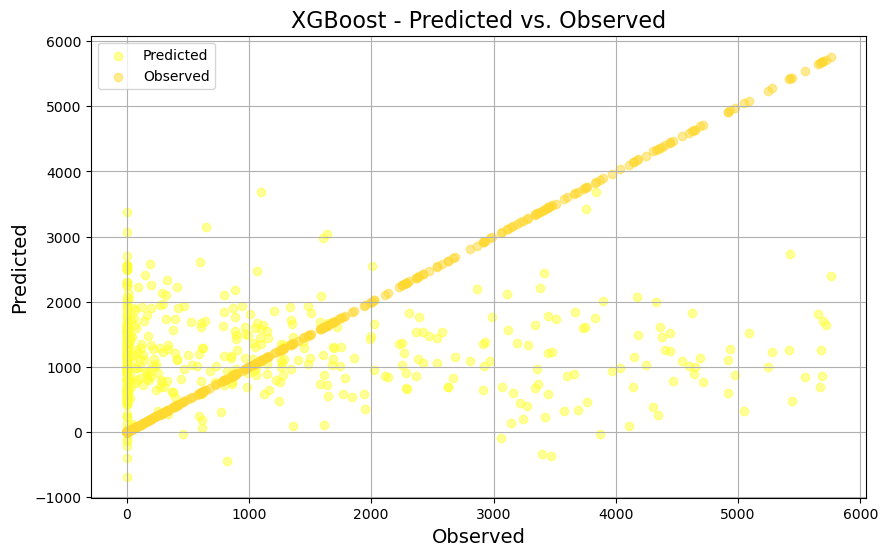

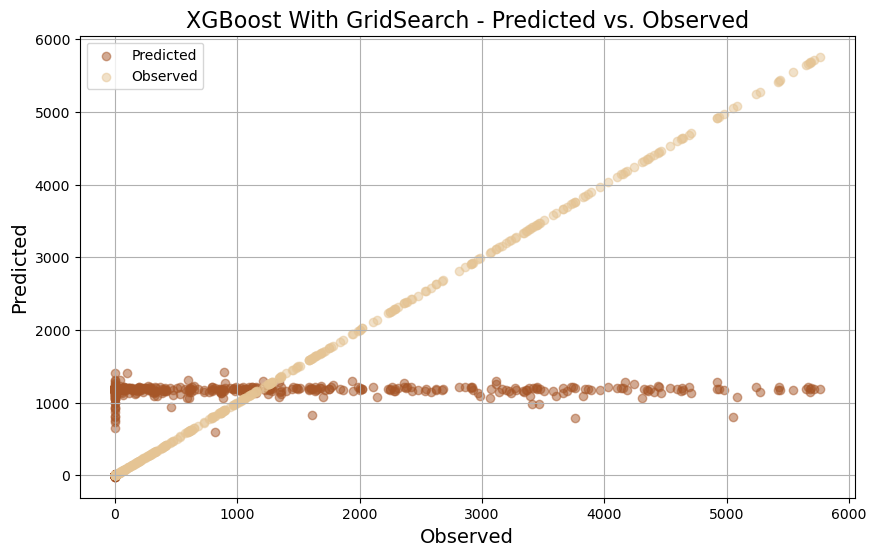

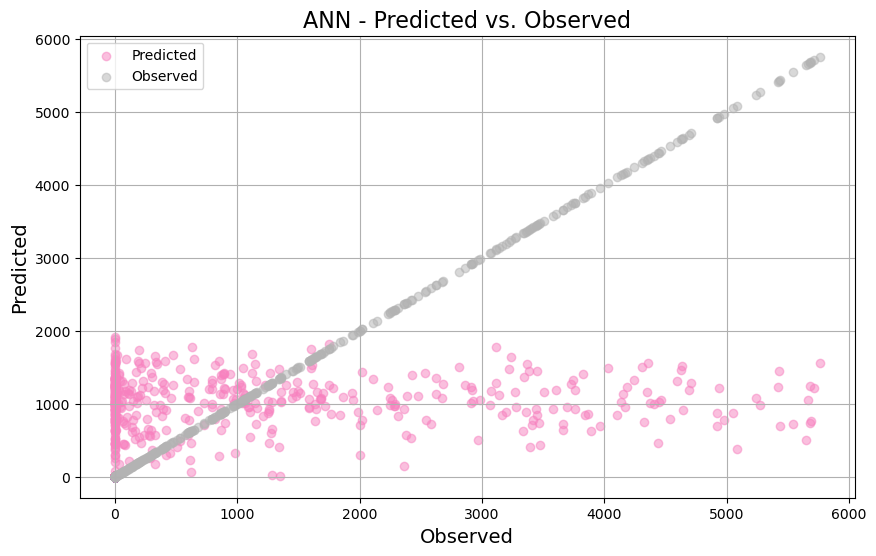

In [78]:
# Define palette of colors
palette_pred = sns.color_palette("Set1", n_colors=len(model_names))
palette_obs = sns.color_palette("Set2", n_colors=len(model_names))

# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'SVR', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin_Ind, test_predict_poly_Ind, test_predict_svr_Ind, test_predict_rf_Ind, y_pred_rf_grid_Ind, y_pred_xgb_Ind, y_pred_xgb_grid_Ind, y_pred_rnn_Ind]

# Create DataFrame for predictions
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})

# Add observed values to the DataFrame
df_predictions['Observed'] = y_test_Ind.values

# Plotting predictions vs. observed for each model with different colors for predicted and observed values
for i, model in enumerate(model_names):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_predictions['Observed'], df_predictions[f'y_pred_{model}'], alpha=0.5, color=palette_pred[i], label='Predicted')
    plt.scatter(df_predictions['Observed'], df_predictions['Observed'], alpha=0.5, color=palette_obs[i], label='Observed')
    plt.title(f'{model} - Predicted vs. Observed', fontsize=16)
    plt.xlabel('Observed', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

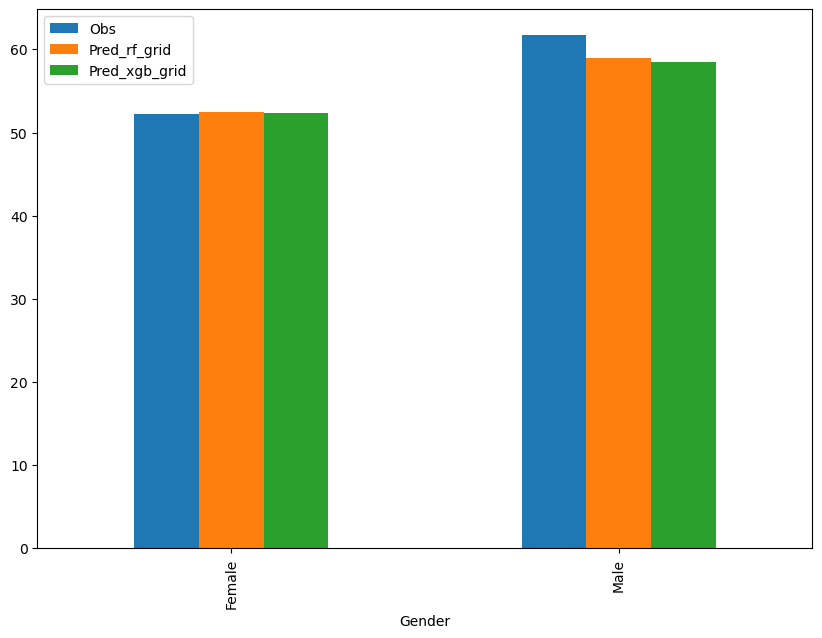

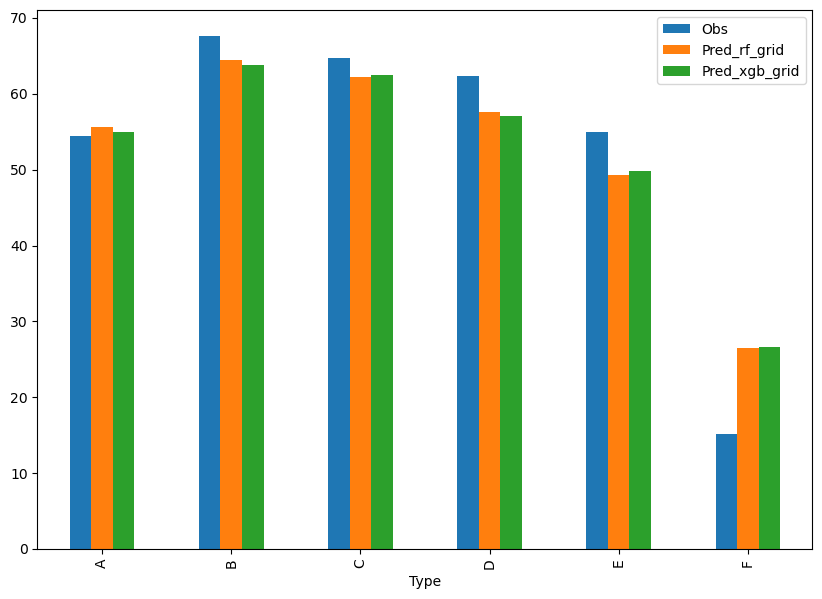

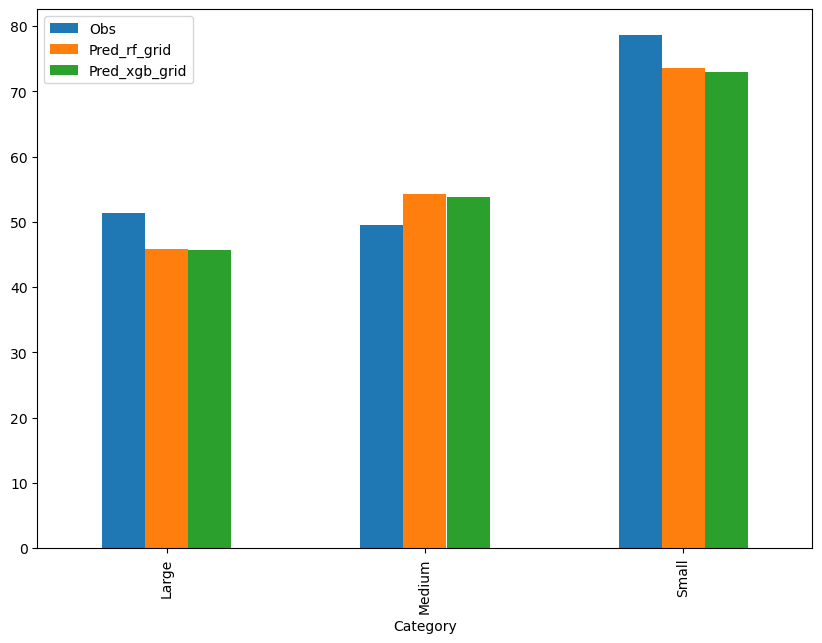

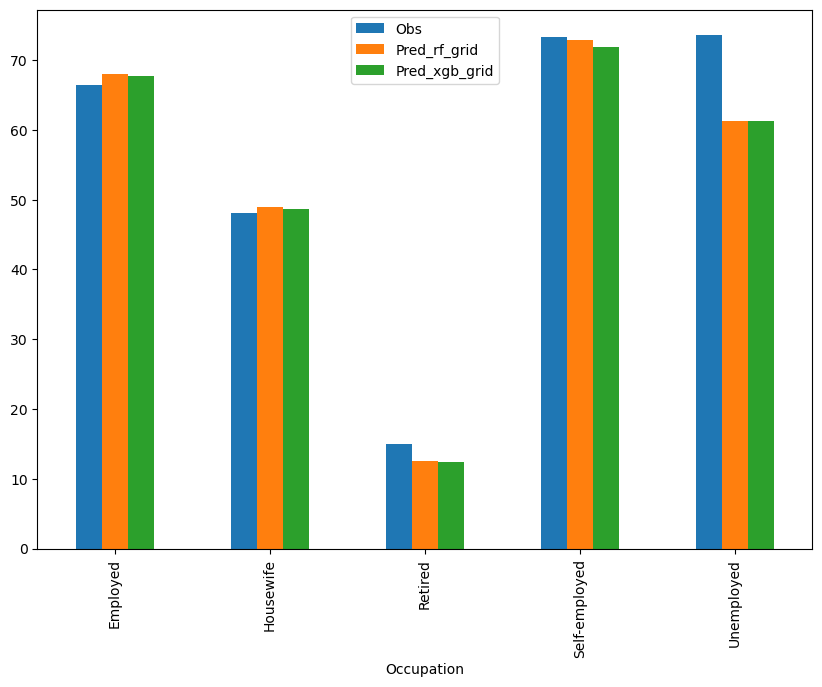

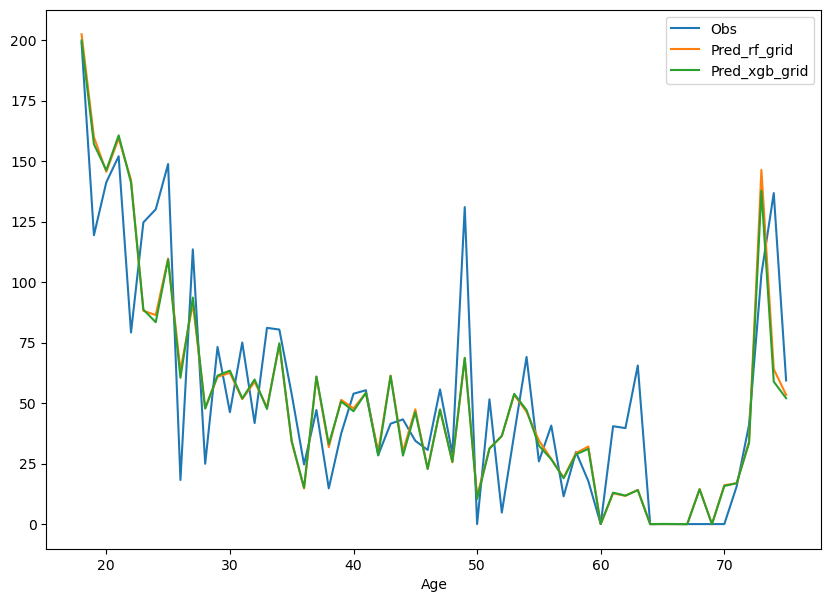

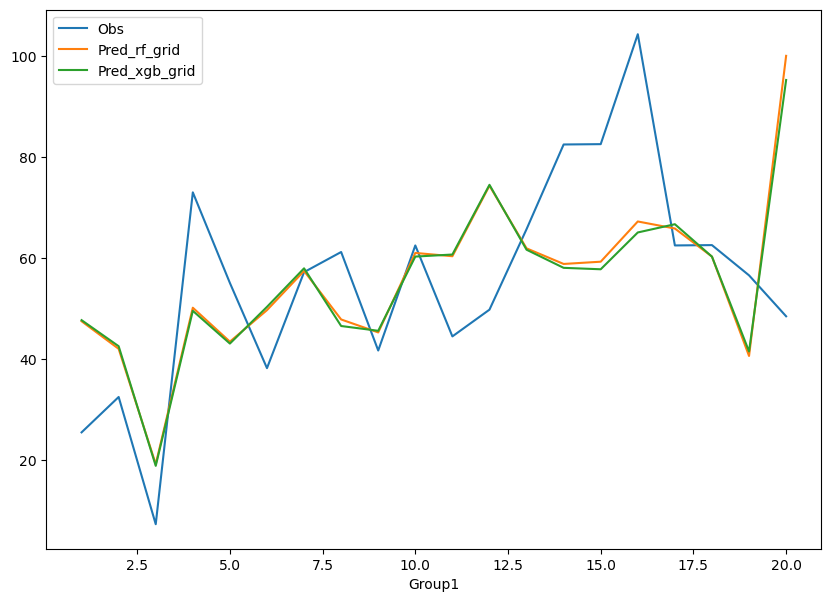

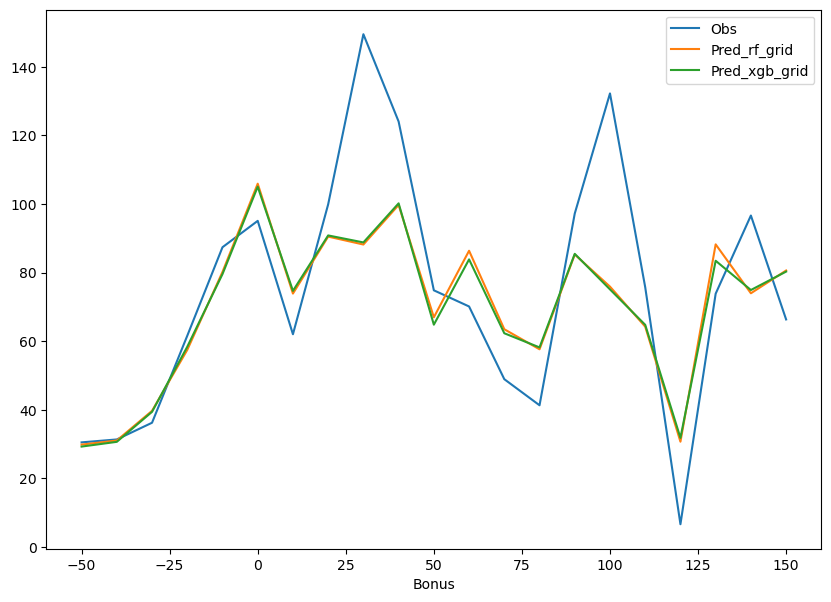

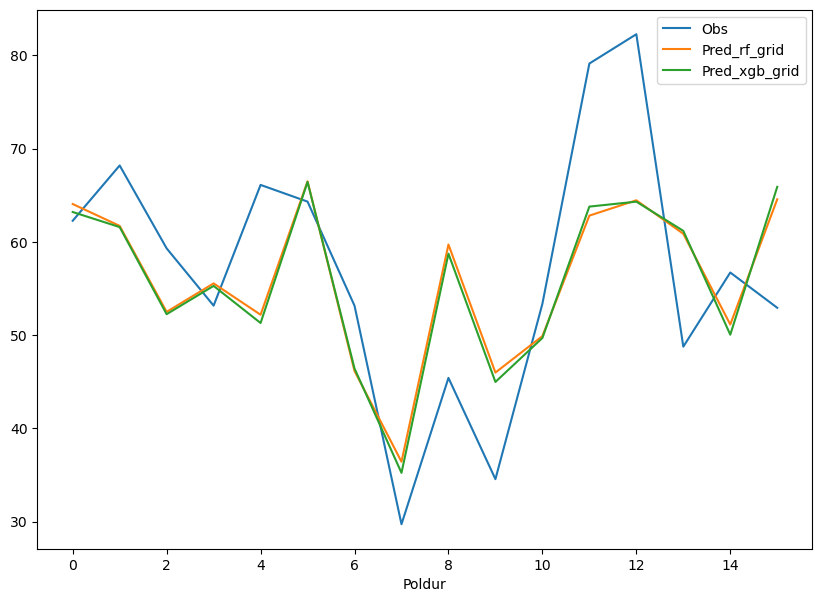

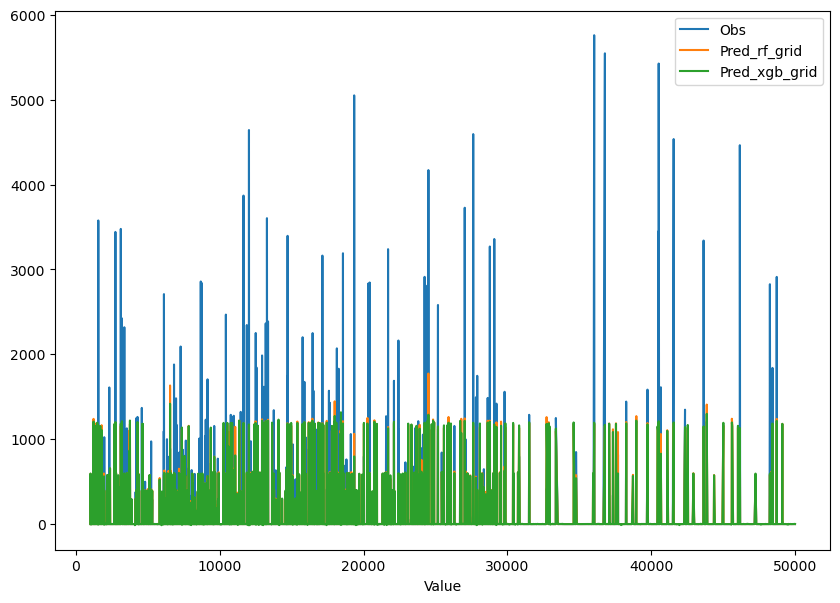

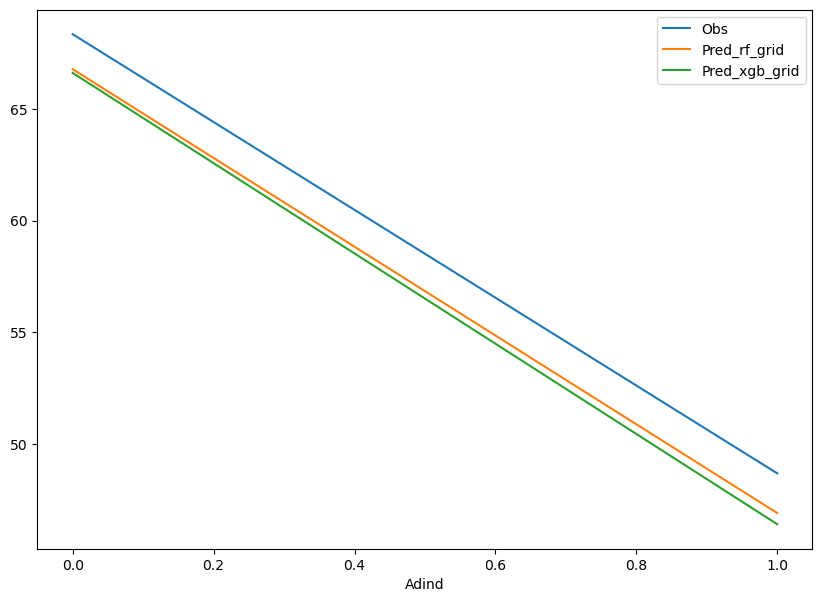

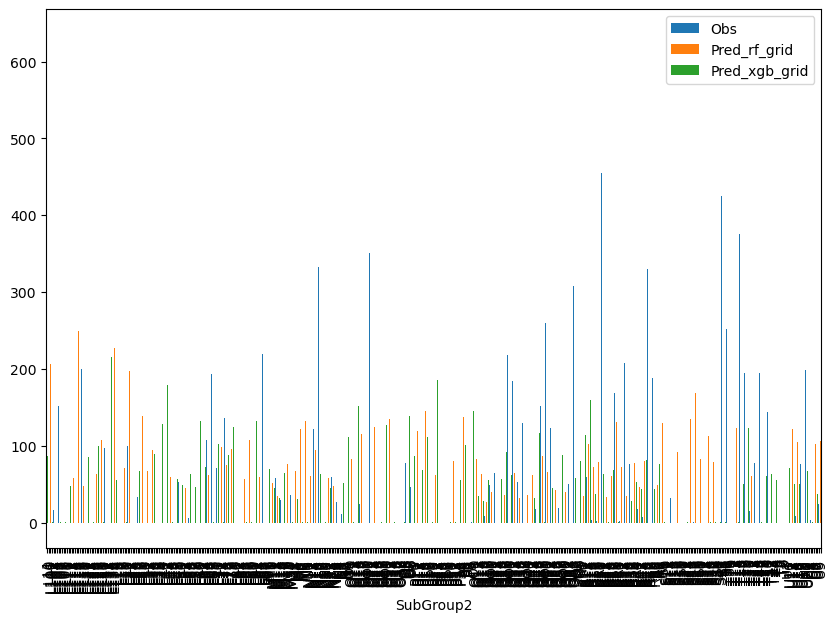

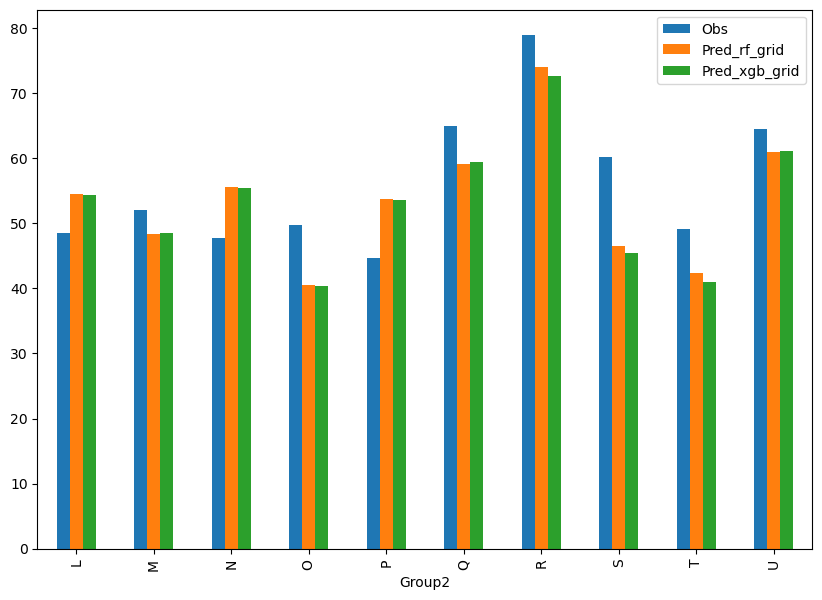

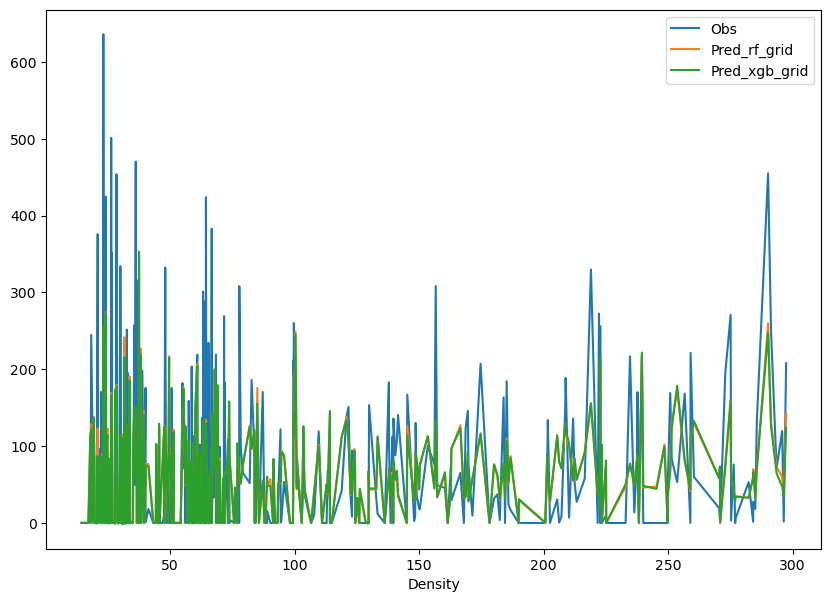

In [203]:
#Impact of target variable on the remaining variables
dataProv = pd.DataFrame(y_test.index)
dataProv.columns = ['index']
dataProv['Obs'] = np.array(y_test_Ind)
dataProv['Pred_rf_grid'] = y_pred_rf_grid_Ind
dataProv['Pred_xgb_grid'] = y_pred_xgb_grid_Ind
# dataProv['Pred_xgb_grid'] = p_xgb_grid
dataProv.head()

dataFinale = training_data.copy().reset_index().merge(dataProv)
dataFinale.head()
palette = "deep"

for var in dataFinale.columns[3:16]:
    dataPlot = dataFinale.groupby([var])[['Obs', 'Pred_rf_grid', 'Pred_xgb_grid']].mean()
    
    if dataFinale[var].dtypes == 'O':
        # Créer un graphique à barres avec des couleurs de la palette
        ax = dataPlot.plot(kind='bar', figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))
    else:
        # Créer un graphique linéaire avec des couleurs de la palette
        ax = dataPlot.plot(figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))

plt.show()

#### Step B : Predicting Prime PBI

In [204]:
# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'SVR', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin, test_predict_poly, test_predict_svr, test_predict_rf_model, y_pred_rf_grid_model, y_pred_xgb_model, y_pred_xgb_grid_model, y_pred_ann_model]

# List of true values for comparison
y_true = y_test  # Assuming y_test contains the true values

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_true, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_true, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_true, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_true, y_pred) for y_pred in all_y_pred]
}

# Debugging: Print shapes of all_y_pred
for i, y_pred in enumerate(all_y_pred):
    print(f'Shape of y_pred_{model_names[i]}: {y_pred.shape}')

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)


Shape of y_pred_Linear Regression: (10003,)
Shape of y_pred_Polynomial Regression: (10003,)
Shape of y_pred_SVR: (10003,)
Shape of y_pred_Random Forest: (10003,)
Shape of y_pred_Random Forest With GridSearch: (10003,)
Shape of y_pred_XGBoost: (10003,)
Shape of y_pred_XGBoost With GridSearch: (10003,)
Shape of y_pred_ANN: (10003, 1)

Predictions DataFrame:


,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_SVR,y_pred_Random Forest,y_pred_Random Forest With GridSearch,y_pred_XGBoost,y_pred_XGBoost With GridSearch,y_pred_ANN
0,0.555991,1.307399e-12,0.099753,0.000000,8.410949e-07,0.001011,0.002261,0.585324
1,-2.833974,4.831691e-13,0.099492,0.000000,8.410949e-07,0.001011,0.002261,0.585324
2,-1.008189,7.958079e-13,0.099827,0.000000,8.410949e-07,0.001011,0.002261,0.585324
3,334.055194,2.850955e+02,285.185641,285.591776,2.857473e+02,284.504700,284.507324,273.859283
4,-1.170761,2.842171e-14,0.099957,0.000000,8.410949e-07,0.001011,0.002261,0.585324
...,...,...,...,...,...,...,...,...
9998,-0.236147,-6.536993e-13,0.099715,0.000000,8.410949e-07,0.001011,0.002261,0.585324
9999,-0.194034,-2.273737e-13,0.099967,0.000000,8.410949e-07,0.001011,0.002261,0.585324
10000,-1.376086,2.842171e-13,0.099959,0.000000,8.410949e-07,0.001011,0.002261,0.585324
10001,-7.236848,-6.536993e-13,0.099544,0.000000,8.410949e-07,0.001011,0.002261,0.605167


In [205]:
print("\nMetrics DataFrame:")
(df_metrics)


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,7.347322e+00,8.858640e+03,9.412035e+01,0.958069
1,Polynomial Regression,4.348188e-13,3.468463e-25,5.889366e-13,1.000000
2,SVR,2.854286e+00,9.417553e+03,9.704408e+01,0.955424
3,Random Forest,3.827326e-01,1.666164e+02,1.290800e+01,0.999211
4,Random Forest With GridSearch,3.557215e-01,1.311393e+02,1.145161e+01,0.999379
5,XGBoost,6.016319e-01,2.384166e+02,1.544074e+01,0.998871
6,XGBoost With GridSearch,4.066371e-01,3.089087e+01,5.557956e+00,0.999854
7,ANN,2.328420e+00,2.878267e+02,1.696546e+01,0.998638
